In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tqdm
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail
import requests
from nba_api.stats.static.players import find_players_by_full_name
from adjustText import adjust_text
from io import BytesIO
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import time
from PIL import Image
from collections import defaultdict

In [2]:
from nba_api.stats.endpoints.playbyplayv2 import PlayByPlayV2

from nba_api.stats.endpoints.playbyplay import PlayByPlay
from nba_api.stats.endpoints.leaguegamefinder import LeagueGameFinder
from nba_api.stats.static.players import find_players_by_full_name
from nba_api.stats.static.teams import find_teams_by_full_name
from nba_api.stats.endpoints.playergamelogs import PlayerGameLogs
from nba_api.stats.endpoints.boxscoretraditionalv2 import BoxScoreTraditionalV2
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail

from nba_api.stats.endpoints.leaguedashteamshotlocations import LeagueDashTeamShotLocations
from nba_api.stats.endpoints.leaguedashplayerptshot import LeagueDashPlayerPtShot

from nba_api.stats.endpoints.synergyplaytypes import SynergyPlayTypes
from nba_api.stats.endpoints.leaguedashptstats import LeagueDashPtStats
from nba_api.stats.endpoints.leaguedashplayerstats import LeagueDashPlayerStats

from nba_api.stats.endpoints.leaguehustlestatsplayer import LeagueHustleStatsPlayer

In [3]:
plt.style.use('fivethirtyeight')

In [5]:
pbp_df = pd.read_csv('pbp_data/2021-22.csv')

In [6]:
pbp_df = pbp_df.fillna({
    "HOMEDESCRIPTION": "",
    "NEUTRALDESCRIPTION": "",
    "VISITORDESCRIPTION": ""
})
pbp_df.loc[:, 'GAME_ID'] = [f"00{item}" for item in pbp_df.GAME_ID.astype(str)]

In [7]:
blocked_shots = pbp_df.loc[(pbp_df.HOMEDESCRIPTION.str.contains("BLK")) | (pbp_df.VISITORDESCRIPTION.str.contains("BLK"))]

In [8]:
player_stats = LeagueDashPlayerStats(season='2021-22', per_mode_detailed='Totals').get_data_frames()[0]



In [9]:
top_blockers = player_stats.sort_values(by='BLK', ascending=False).iloc[:60]

In [10]:
blocked_shots = blocked_shots.loc[blocked_shots.PLAYER3_ID.isin(top_blockers.PLAYER_ID.tolist())]

In [11]:
next_events = []
for index in tqdm.tqdm(range(len(blocked_shots))):
    item = blocked_shots.iloc[index]
    next_item = pbp_df.iloc[pbp_df.loc[(pbp_df.GAME_ID == item.GAME_ID) & (pbp_df.EVENTNUM == item.EVENTNUM)].iloc[0].name+1]
    next_events.append(next_item.EVENTNUM)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4484/4484 [03:07<00:00, 23.92it/s]


In [12]:
blocked_shots.loc[:, 'NEXT_EVENTNUM'] = next_events

In [13]:
merged_blocks = pd.merge(left=blocked_shots, right=pbp_df, left_on=('GAME_ID', 'NEXT_EVENTNUM'), right_on=('GAME_ID', 'EVENTNUM'), suffixes=('_BLK', '_NEXT'))

In [14]:
merged_blocks.PLAYER3_TEAM_ID_BLK = merged_blocks.PLAYER3_TEAM_ID_BLK.astype('str')
merged_blocks.PLAYER1_TEAM_ID_NEXT = merged_blocks.PLAYER1_TEAM_ID_NEXT.astype('str')

In [15]:
reformatted_dfs = []
for index in range(len(top_blockers)):
    item = top_blockers.iloc[index]
    player_id = item.PLAYER_ID
    player_blocks = merged_blocks.loc[merged_blocks.PLAYER3_ID_BLK == player_id]
    is_successful = []
    for cur_index in range(len(player_blocks)):
        block_item = player_blocks.iloc[cur_index]
        if block_item.PLAYER1_TEAM_ID_NEXT == 'nan':
            if str(block_item.PLAYER1_ID_NEXT) == str(block_item.PLAYER3_TEAM_ID_BLK).split(".")[0]:
                is_successful.append(1)
            else:
                is_successful.append(0)
        else:
            if str(block_item.PLAYER1_TEAM_ID_NEXT) == str(block_item.PLAYER3_TEAM_ID_BLK):
                is_successful.append(1)
            else:
                is_successful.append(0)
    player_blocks.loc[:, 'SUCCESSFUL'] = is_successful
    reformatted_dfs.append(player_blocks)

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [16]:
concat_top_blockers = pd.concat(reformatted_dfs)

In [17]:
group_top = concat_top_blockers.groupby('PLAYER3_NAME_BLK').SUCCESSFUL.value_counts().unstack(level=1).reset_index()

In [18]:
renamed_group = group_top.rename(
    columns={
        0: 'UNSUCCESSFUL',
        1: 'SUCCESSFUL'
    }
)

In [19]:
renamed_group.loc[:, 'TOTAL'] = renamed_group.UNSUCCESSFUL + renamed_group.SUCCESSFUL
renamed_group.loc[:, 'SUCC_PCT'] = renamed_group.SUCCESSFUL / renamed_group.TOTAL * 100

In [22]:
sort_blocked = renamed_group.sort_values(by='TOTAL', ascending=False)

In [23]:
sort_blocked

SUCCESSFUL       PLAYER3_NAME_BLK  UNSUCCESSFUL  SUCCESSFUL  TOTAL   SUCC_PCT
27              Jaren Jackson Jr.            90          84    174  48.275862
57                    Rudy Gobert            53          82    135  60.740741
56            Robert Williams III            64          70    134  52.238806
45              Mitchell Robinson            53          80    133  60.150376
47                   Myles Turner            45          73    118  61.864407
26                   Jakob Poeltl            40          77    117  65.811966
46                       Mo Bamba            42          75    117  64.102564
15                    Evan Mobley            32          77    109  70.642202
18               Hassan Whiteside            35          65    100  65.000000
32                    Joel Embiid            42          56     98  57.142857
11                 Daniel Gafford            40          56     96  58.333333
16          Giannis Antetokounmpo            29          62     91  68.131868
0                      Al Horford            33          58     91  63.736264
10                   Clint Capela            32          59     91  64.835165
55               Robert Covington            44          47     91  51.648352
4                   Anthony Davis            39          51     90  56.666667
38             Kristaps Porzingis            28          56     84  66.666667
35             Karl-Anthony Towns            30          53     83  63.855422
24                   JaVale McGee            22          58     80  72.500000
22                 Isaiah Stewart            22          54     76  71.052632
23                    Ivica Zubac            20          55     75  73.333333
28                  Jarrett Allen            30          45     75  60.000000
20             Isaiah Hartenstein            28          47     75  62.666667
8                   Chris Boucher            28          46     74  62.162162
51                 Nikola Vucevic            28          43     71  60.563380
12                  Darius Bazley            22          48     70  68.571429
48                       Naz Reid            33          36     69  52.173913
42               Matisse Thybulle            30          39     69  56.521739
6                  Brandon Clarke            22          46     68  67.647059
1                  Alperen Sengun            30          37     67  55.223881
9                  Christian Wood            27          39     66  59.090909
44                  Miles Bridges            26          39     65  60.000000
2                  Andre Drummond            25          40     65  61.538462
50                   Nikola Jokic            27          36     63  57.142857
34              Jonas Valanciunas            14          46     60  76.666667
52                 Onyeka Okongwu            26          33     59  55.932203
40                   LeBron James            23          36     59  61.016949
59                   Steven Adams            28          31     59  52.542373
19                  Herbert Jones            24          35     59  59.322034
53                P.J. Washington            26          32     58  55.172414
43                    Maxi Kleber            26          32     58  55.172414
13                  Derrick White            26          32     58  55.172414
39                     Kyle Kuzma            34          23     57  40.350877
33                   John Collins            19          37     56  66.071429
17                 Grant Williams            24          32     56  57.142857
58                 Scottie Barnes            22          33     55  60.000000
29                   Jaxson Hayes            25          29     54  53.703704
37                   Kevon Looney            16          36     52  69.230769
25                Jaden McDaniels            24          28     52  53.846154
7                 Carmelo Anthony            27          25     52  48.076923
54               Patri

In [24]:
plt.style.use('fivethirtyeight')

In [25]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import Rectangle
zoom = 0.5

player_root_dir = f'player_imgs/'

def get_player_img(player_id, zoom=0.5):
    #print(path)
    return OffsetImage(plt.imread(f'{player_root_dir}{player_id}.png'), zoom=zoom)


In [27]:
sort_blocked = sort_blocked.iloc[:20]

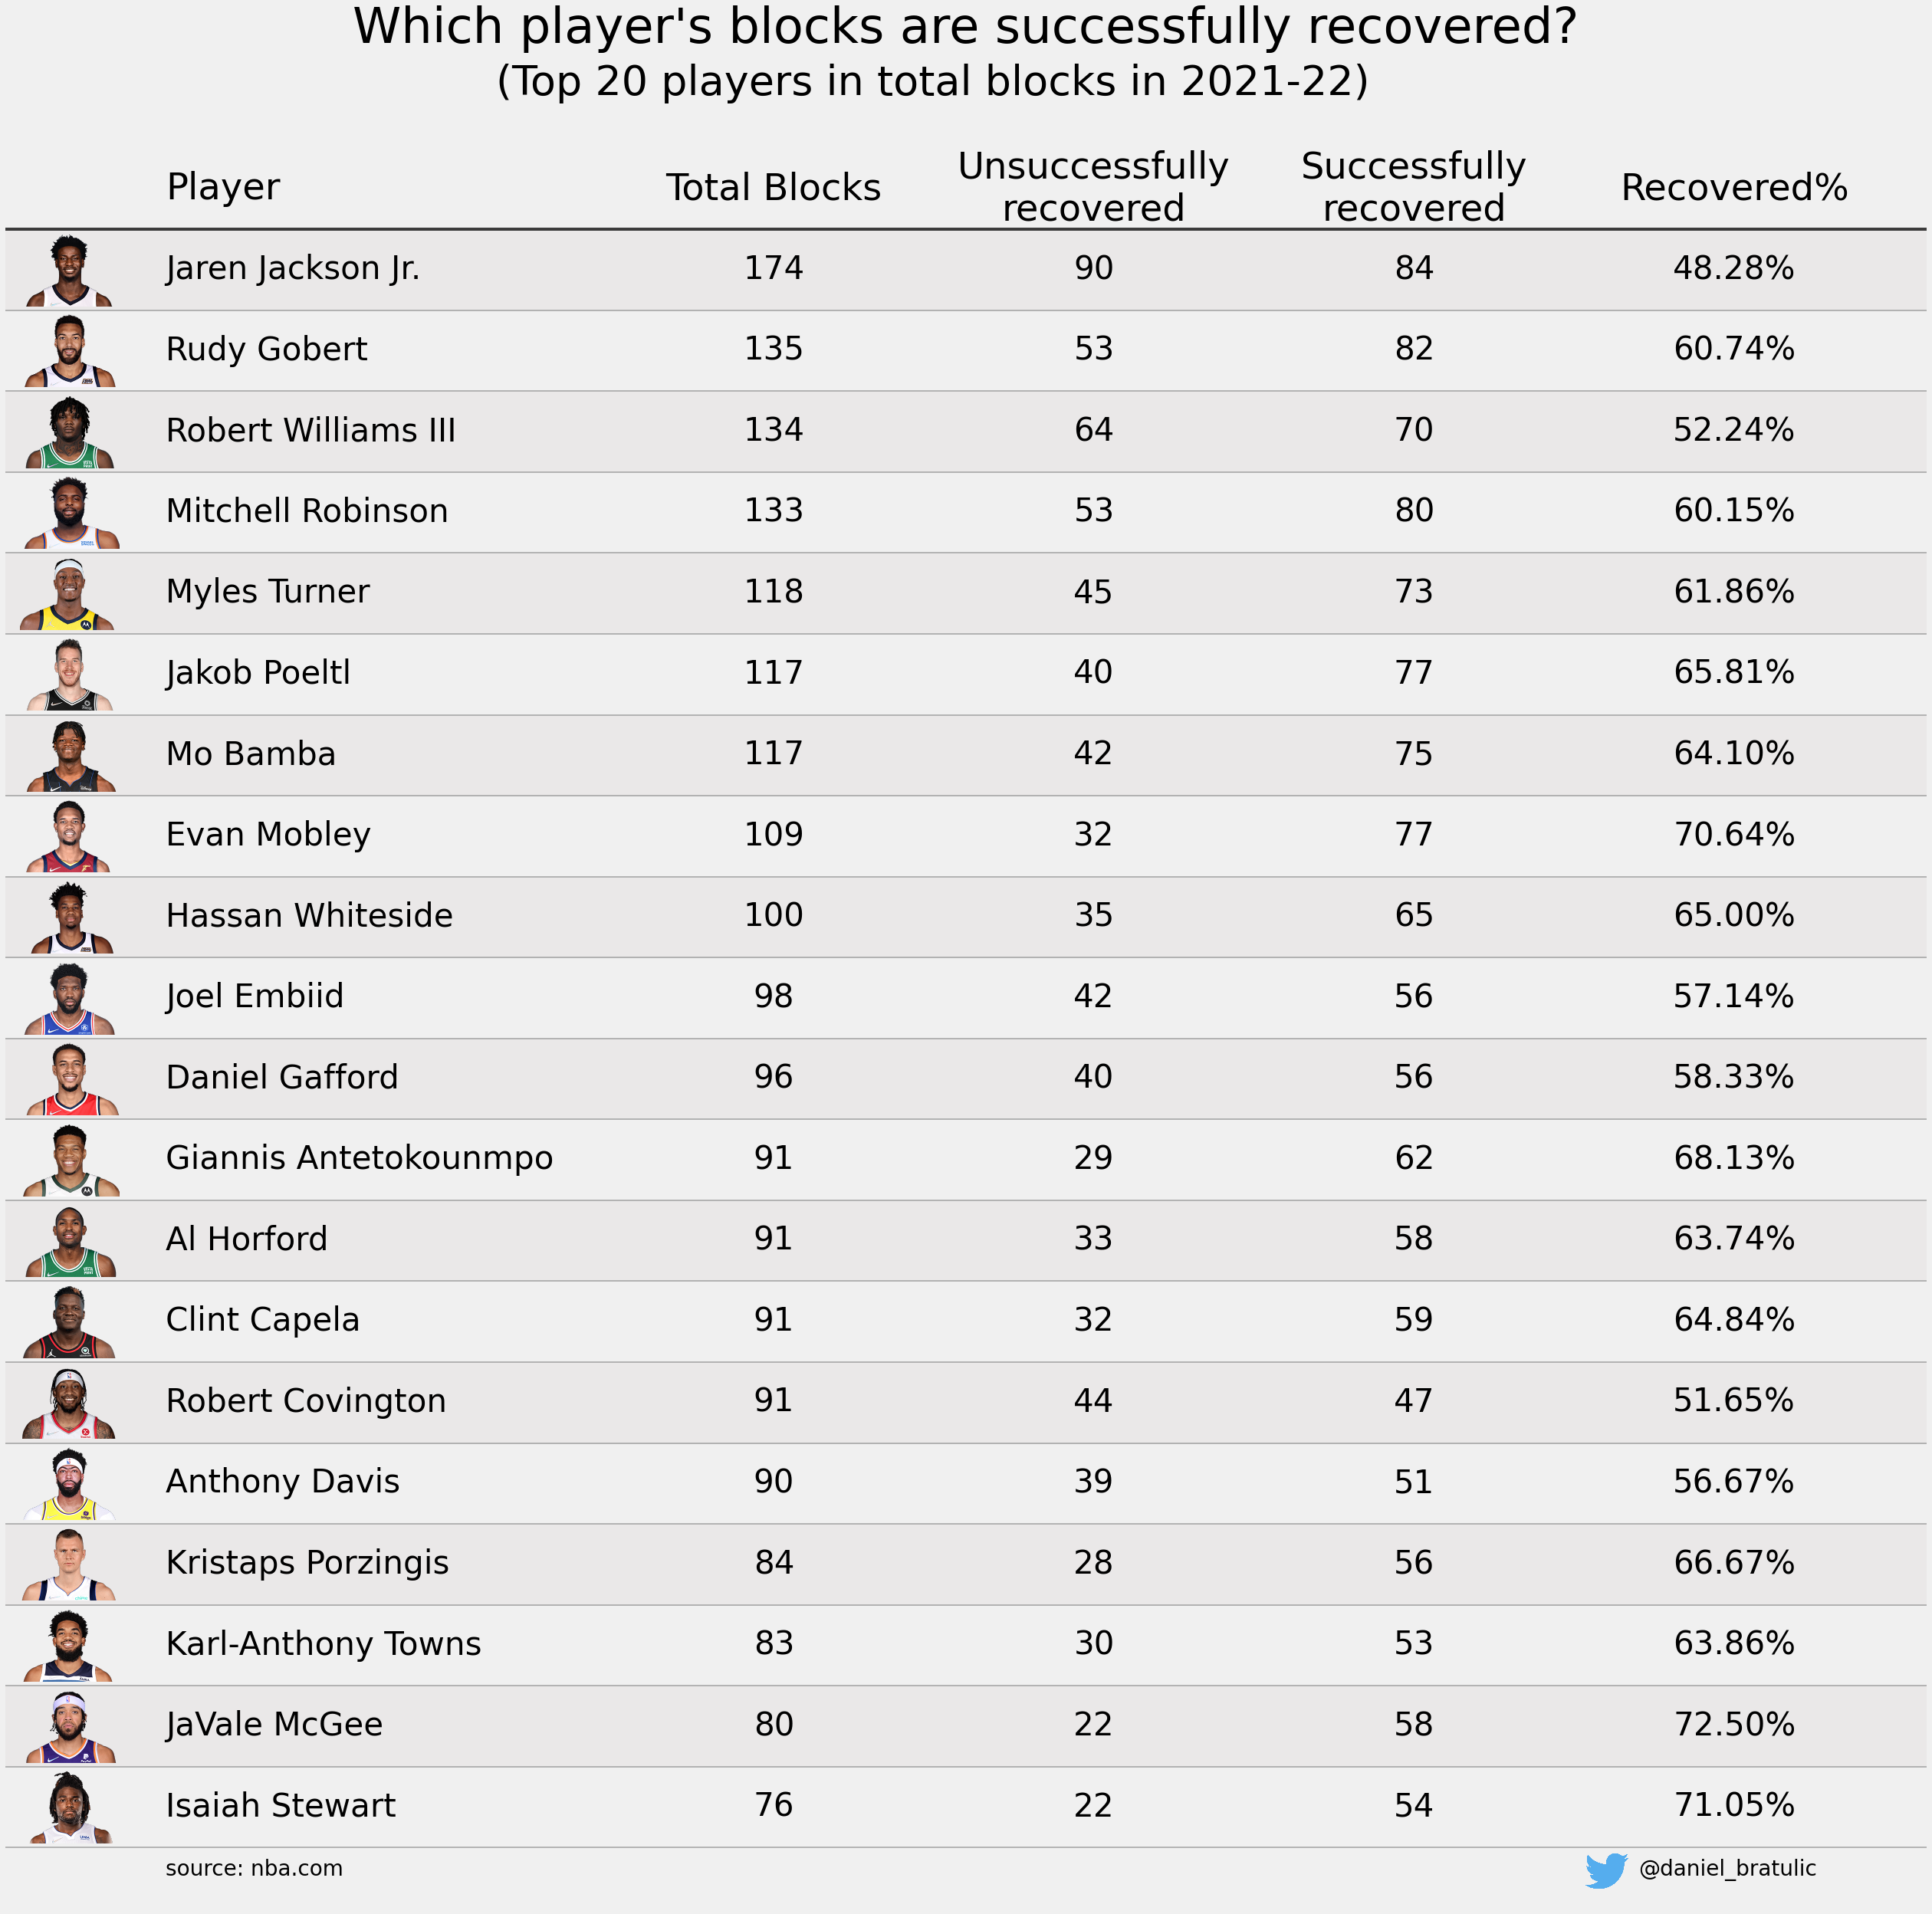

In [36]:
fig, ax = plt.subplots(figsize=(40, 40))
number_size = 42
font_size = 36
font_title = 48
title_size = 64
#top = 10

sorted_open_df = sort_blocked
top = len(sort_blocked)
for i in range(top):
    item = sort_blocked.iloc[i]
    try:
        player_id = find_players_by_full_name(item.PLAYER3_NAME_BLK)[0]['id']
    except Exception:
        continue
    y_coord = top - i - 1
    if i % 2 == 1:
        color = '#EAE8E8'
        rect = Rectangle((-4.5, y_coord + 0.5), width=15, height=1, fill=True, color=color)
        ax.add_patch(rect)
    
    ab = AnnotationBbox(get_player_img(player_id), (0.1, y_coord), frameon=False)
    ax.add_artist(ab)
    #ax.text(x=0.25, y=y_coord, ha='left', va='center', s=item.SEASON, size=font_size)
    ax.text(x=0.25, y=y_coord, ha='left', va='center', s=item.PLAYER3_NAME_BLK, size=number_size)
    ax.axhline(y=y_coord-0.5, xmin=-0.25, xmax=10, color='#A0A0A0', alpha=0.75, lw=2)
    
    ax.text(x=1.2, y=y_coord, ha='center', va='center', s=f"{item.TOTAL}", size=number_size)
    ax.text(x=1.7, y=y_coord, ha='center', va='center', s=f"{item.UNSUCCESSFUL}", size=number_size)
    ax.text(x=2.2, y=y_coord, ha='center', va='center', s=f"{item.SUCCESSFUL}", size=number_size)
    ax.text(x=2.7, y=y_coord, ha='center', va='center', s=f"{item.SUCC_PCT:.2f}%", size=number_size)
    
    #y_img_start = y_coord-0.5 + (1 - 0.730769232) / 2
    #ax.imshow(img, extent=(0, 1.36, y_img_start-0.5, y_img_start + 0.1), aspect='auto')
    #ax.imshow(img, extent=(0, 260, 0, 190), aspect=260/190)
    
#ax.text(x=0.25, y=top, s='Season', ha='left', va='center', size=font_title)
ax.text(x=0.25, y=top, s='Player', ha='left', va='center', size=font_title)
ax.text(x=1.2, y=top, ha='center', va='center', s="Total Blocks", size=font_title)
ax.text(x=1.7, y=top, ha='center', va='center', s="Unsuccessfully\nrecovered", size=font_title)
ax.text(x=2.2, y=top, ha='center', va='center', s="Successfully\nrecovered", size=font_title)
ax.text(x=2.7, y=top, ha='center', va='center', s="Recovered%", size=font_title)

#ax.text(x=2.75, y=-0.75, s='twitter: @daniel_bratulic', ha='right', va='center', size=30)
#ax.text(x=0.25, y=-0.75, s='data: nba.com', ha='left', va='center', size=30)
ax.axhline(y=top-0.5, xmin=-0.25, xmax=10, color='black', alpha=0.75, lw=4)
ax.set_title("Which player's blocks are successfully recovered?\n", size=title_size)
plt.suptitle("(Top 20 players in total blocks in 2021-22)", size=title_size-10, y=0.9, )
    
ax.set_ylim(bottom=-1.1, top=top+1)
ax.set_xlim(left=-0, right=3)
ax.grid(False)
ax.set_frame_on(False)
ax.set_yticklabels([])
ax.set_xticklabels([])
ab = AnnotationBbox(OffsetImage(plt.imread(f'../../twitter_logo.png'), zoom=0.05), (2.5, -0.8), frameon=False)
ax.add_artist(ab)
ax.text(x=2.55, y=-0.85, ha='left', s='@daniel_bratulic', size=28)
ax.text(x=0.25, y=-0.85, ha='left', s='source: nba.com', size=28)
plt.savefig('block_recoveries.png', dpi=120, bbox_inches='tight')

### Historical numbers

In [5]:
seasons = [f"{item}-{str(item+1)[-2:]}" for item in range(2000, 2022)]

In [6]:
seasons

['2000-01',
 '2001-02',
 '2002-03',
 '2003-04',
 '2004-05',
 '2005-06',
 '2006-07',
 '2007-08',
 '2008-09',
 '2009-10',
 '2010-11',
 '2011-12',
 '2012-13',
 '2013-14',
 '2014-15',
 '2015-16',
 '2016-17',
 '2017-18',
 '2018-19',
 '2019-20',
 '2020-21']

In [77]:

per_season_data = []
for season in seasons:
    print(season)
    pbp_df = pd.read_csv(f'pbp_analysis/pbp_data/{season}.csv')
    pbp_df = pbp_df.fillna({
        "HOMEDESCRIPTION": "",
        "NEUTRALDESCRIPTION": "",
        "VISITORDESCRIPTION": ""
    })
    pbp_df.loc[:, 'GAME_ID'] = [f"00{item}" for item in pbp_df.GAME_ID.astype(str)]
    blocked_shots = pbp_df.loc[(pbp_df.HOMEDESCRIPTION.str.contains("BLK")) | (pbp_df.VISITORDESCRIPTION.str.contains("BLK"))]
    
    player_stats = LeagueDashPlayerStats(season=season, per_mode_detailed='Totals').get_data_frames()[0]
    top_blockers = player_stats.sort_values(by='BLK', ascending=False).iloc[:5]
    blocked_shots = blocked_shots.loc[blocked_shots.PLAYER3_ID.isin(top_blockers.PLAYER_ID.tolist())]
    next_events = []
    for index in tqdm.tqdm(range(len(blocked_shots))):
        item = blocked_shots.iloc[index]
        next_item = pbp_df.iloc[pbp_df.loc[(pbp_df.GAME_ID == item.GAME_ID) & (pbp_df.EVENTNUM == item.EVENTNUM)].iloc[0].name+1]
        next_events.append(next_item.EVENTNUM)
    
    blocked_shots.loc[:, 'NEXT_EVENTNUM'] = next_events
    merged_blocks = pd.merge(left=blocked_shots, right=pbp_df, left_on=('GAME_ID', 'NEXT_EVENTNUM'), right_on=('GAME_ID', 'EVENTNUM'), suffixes=('_BLK', '_NEXT'))
    #player_stats = LeagueDashPlayerStats(season=season, per_mode_detailed='Totals').get_data_frames()[0]
    #top_blockers = player_stats.sort_values(by='BLK', ascending=False).iloc[:10]
    merged_blocks.PLAYER3_TEAM_ID_BLK = merged_blocks.PLAYER3_TEAM_ID_BLK.astype('str')
    merged_blocks.PLAYER1_TEAM_ID_NEXT = merged_blocks.PLAYER1_TEAM_ID_NEXT.astype('str')
    reformatted_dfs = []
    for index in range(len(top_blockers)):
        item = top_blockers.iloc[index]
        player_id = item.PLAYER_ID
        player_blocks = merged_blocks.loc[merged_blocks.PLAYER3_ID_BLK == player_id]
        is_successful = []
        for cur_index in range(len(player_blocks)):
            block_item = player_blocks.iloc[cur_index]
            if block_item.PLAYER1_TEAM_ID_NEXT == 'nan':
                if str(block_item.PLAYER1_ID_NEXT) == str(block_item.PLAYER3_TEAM_ID_BLK).split(".")[0]:
                    is_successful.append(1)
                else:
                    is_successful.append(0)
            else:
                if str(block_item.PLAYER1_TEAM_ID_NEXT) == str(block_item.PLAYER3_TEAM_ID_BLK):
                    is_successful.append(1)
                else:
                    is_successful.append(0)
        player_blocks.loc[:, 'SUCCESSFUL'] = is_successful
        reformatted_dfs.append(player_blocks)
        concat_top_blockers = pd.concat(reformatted_dfs)

    group_top = concat_top_blockers.groupby('PLAYER3_NAME_BLK').SUCCESSFUL.value_counts().unstack(level=1).reset_index()
    renamed_group = group_top.rename(
        columns={
            0: 'UNSUCCESSFUL',
            1: 'SUCCESSFUL'
        }
    )
    renamed_group.loc[:, 'TOTAL'] = renamed_group.UNSUCCESSFUL + renamed_group.SUCCESSFUL
    renamed_group.loc[:, 'SUCC_PCT'] = renamed_group.SUCCESSFUL / renamed_group.TOTAL * 100
    renamed_group.loc[:, 'SEASON'] = season
    renamed_group.loc[:, 'GP'] = top_blockers.GP
    per_season_data.append(renamed_group)

2000-01



 21%|████████████████████████████████████▏                                                                                                                                       | 225/1069 [00:08<00:35, 23.69it/s]


 42%|█████████████████████████████████████████████████████████████████████████                                                                                                   | 454/1069 [00:17<00:23, 25.85it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 682/1069 [00:25<00:13, 28.53it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 911/1069 [00:34<00:05, 28.15it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1069/1069 [00:39<00:00, 26.80it/s]
c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

2001-02



 22%|██████████████████████████████████████▍                                                                                                                                     | 239/1070 [00:08<00:29, 28.37it/s]


 45%|██████████████████████████████████████████████████████████████████████████████                                                                                              | 486/1070 [00:17<00:21, 27.52it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 723/1070 [00:25<00:12, 27.88it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 957/1070 [00:33<00:03, 28.29it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1070/1070 [00:37<00:00, 28.54it/s]


2002-03



 20%|███████████████████████████████████                                                                                                                                         | 227/1112 [00:08<00:30, 28.77it/s]


 41%|██████████████████████████████████████████████████████████████████████▊                                                                                                     | 458/1112 [00:16<00:24, 26.93it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 690/1112 [00:24<00:14, 28.63it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 918/1112 [00:32<00:06, 28.92it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1112/1112 [00:39<00:00, 28.23it/s]


2003-04



 19%|█████████████████████████████████▍                                                                                                                                          | 227/1168 [00:08<00:32, 28.64it/s]


 40%|████████████████████████████████████████████████████████████████████                                                                                                        | 462/1168 [00:16<00:24, 29.04it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 714/1168 [00:25<00:16, 27.21it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 984/1168 [00:34<00:06, 29.45it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:40<00:00, 28.95it/s]


2004-05



 25%|███████████████████████████████████████████▊                                                                                                                                 | 225/889 [00:07<00:23, 28.50it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 453/889 [00:15<00:15, 28.73it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 681/889 [00:23<00:07, 26.69it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 889/889 [00:31<00:00, 28.42it/s]


2005-06



 23%|███████████████████████████████████████▏                                                                                                                                     | 225/994 [00:07<00:26, 28.90it/s]


 46%|██████████████████████████████████████████████████████████████████████████████▊                                                                                              | 453/994 [00:15<00:18, 28.84it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 681/994 [00:23<00:10, 29.01it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 909/994 [00:31<00:02, 28.85it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [00:34<00:00, 28.72it/s]


2006-07



 23%|███████████████████████████████████████▎                                                                                                                                     | 225/989 [00:07<00:27, 27.99it/s]


 46%|███████████████████████████████████████████████████████████████████████████████▏                                                                                             | 453/989 [00:15<00:18, 28.82it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 681/989 [00:23<00:10, 28.25it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 909/989 [00:31<00:02, 28.19it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 989/989 [00:34<00:00, 28.53it/s]


2007-08



 22%|█████████████████████████████████████                                                                                                                                       | 225/1043 [00:07<00:28, 28.37it/s]


 43%|██████████████████████████████████████████████████████████████████████████▋                                                                                                 | 453/1043 [00:15<00:20, 29.13it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 681/1043 [00:23<00:12, 28.86it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 910/1043 [00:31<00:04, 26.88it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1043/1043 [00:36<00:00, 28.69it/s]


2008-09



 26%|█████████████████████████████████████████████▌                                                                                                                               | 231/876 [00:07<00:22, 28.62it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 464/876 [00:15<00:14, 29.29it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 697/876 [00:23<00:06, 29.33it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 876/876 [00:30<00:00, 29.00it/s]


2009-10



 25%|████████████████████████████████████████████                                                                                                                                 | 225/884 [00:07<00:23, 28.20it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 454/884 [00:15<00:14, 28.82it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 682/884 [00:23<00:07, 26.07it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 884/884 [00:31<00:00, 28.49it/s]


2010-11



 25%|███████████████████████████████████████████▎                                                                                                                                 | 225/898 [00:07<00:22, 29.33it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 453/898 [00:15<00:15, 28.70it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 681/898 [00:23<00:07, 28.30it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:31<00:00, 28.62it/s]


2011-12



 40%|████████████████████████████████████████████████████████████████████▋                                                                                                        | 300/756 [00:08<00:12, 36.35it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 604/756 [00:16<00:04, 35.23it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 756/756 [00:21<00:00, 35.57it/s]


2012-13



 22%|██████████████████████████████████████                                                                                                                                      | 225/1018 [00:07<00:27, 29.12it/s]


 45%|████████████████████████████████████████████████████████████████████████████▋                                                                                               | 454/1018 [00:15<00:19, 28.96it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 684/1018 [00:24<00:12, 26.64it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 914/1018 [00:32<00:03, 28.68it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1018/1018 [00:35<00:00, 28.48it/s]


2013-14



 24%|█████████████████████████████████████████▉                                                                                                                                   | 226/932 [00:07<00:24, 28.80it/s]


 49%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 455/932 [00:16<00:17, 27.47it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 685/932 [00:24<00:09, 26.68it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 914/932 [00:32<00:00, 28.55it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 932/932 [00:33<00:00, 28.06it/s]


2014-15



 26%|████████████████████████████████████████████▏                                                                                                                                | 225/881 [00:08<00:23, 28.24it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 455/881 [00:16<00:15, 28.34it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 687/881 [00:24<00:06, 27.96it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 881/881 [00:31<00:00, 27.98it/s]


2015-16



 26%|████████████████████████████████████████████▍                                                                                                                                | 226/881 [00:08<00:22, 28.58it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 454/881 [00:16<00:15, 28.10it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 684/881 [00:24<00:07, 28.00it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 881/881 [00:31<00:00, 27.86it/s]


2016-17



 26%|█████████████████████████████████████████████▍                                                                                                                               | 227/865 [00:08<00:22, 28.33it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 457/865 [00:16<00:14, 27.84it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 687/865 [00:24<00:06, 28.17it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 865/865 [00:30<00:00, 28.07it/s]


2017-18



 32%|██████████████████████████████████████████████████████▊                                                                                                                      | 227/717 [00:07<00:17, 28.32it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 458/717 [00:16<00:09, 27.46it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 688/717 [00:24<00:01, 28.48it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 717/717 [00:25<00:00, 28.39it/s]


2018-19



 26%|████████████████████████████████████████████▌                                                                                                                                | 225/874 [00:08<00:24, 26.17it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 453/874 [00:17<00:16, 26.23it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 681/874 [00:26<00:07, 26.10it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 874/874 [00:33<00:00, 25.88it/s]


2019-20



 35%|███████████████████████████████████████████████████████████▊                                                                                                                 | 266/770 [00:08<00:16, 29.90it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 564/770 [00:18<00:06, 29.86it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 770/770 [00:25<00:00, 30.04it/s]


2020-21


c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 370/599 [00:08<00:05, 41.69it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 599/599 [00:14<00:00, 42.60it/s]


In [78]:
full_data = pd.concat(per_season_data)

In [80]:
full_data.to_csv('blocks_data.csv')

In [94]:
full_data.sort_values(by='SUCC_PCT').iloc[:15]

SUCCESSFUL PLAYER3_NAME_BLK  UNSUCCESSFUL  SUCCESSFUL  TOTAL   SUCC_PCT  \
2             Dwight Howard            96          90    186  48.387097   
3              Ronny Turiaf            85          83    168  49.404762   
1            Chris Andersen            88          87    175  49.714286   
4               Serge Ibaka           119         122    241  50.622407   
1             Dwight Howard            84          92    176  52.272727   
2               Robin Lopez            66          73    139  52.517986   
3                Josh Smith            98         110    208  52.884615   
0            DeAndre Jordan            82          95    177  53.672316   
3              Marcus Camby           107         124    231  53.679654   
4                Tim Duncan            88         102    190  53.684211   
2                 Pau Gasol            69          80    149  53.691275   
1              JaVale McGee            61          71    132  53.787879   
3              Myles Turner            61          71    132  53.787879   
3                Josh Smith            78          94    172  54.651163   
0             Dwight Howard            84         102    186  54.838710   

SUCCESSFUL   SEASON  GP  
2           2010-11 NaN  
3           2008-09 NaN  
1           2008-09 NaN  
4           2011-12 NaN  
1           2007-08 NaN  
2           2013-14 NaN  
3           2005-06 NaN  
0           2015-16 NaN  
3           2006-07 NaN  
4           2006-07 NaN  
2           2015-16 NaN  
1           2011-12 NaN  
3           2019-20 NaN  
3           2009-10 NaN  
0           2012-13 NaN

In [88]:
least_efficient = full_data.sort_values(by='SUCC_PCT').iloc[:15]
most_efficient = full_data.sort_values(by='SUCC_PCT', ascending=False).iloc[:15]

### Least efficient

In [130]:
def get_latest_url(player_id):
    return f"https://cdn.nba.com/headshots/nba/latest/260x190/{player_id}.png"

from pathlib import Path

for player in dpoy_df.PLAYER3_NAME_BLK.tolist():
    player_id = find_players_by_full_name(player)[0]['id']
    print(player, player_id)
    if Path(f'player_imgs/{player_id}.png').exists():
        continue
    url = get_latest_url(player_id)
    response = requests.get(url)
    #img = Image.open(BytesIO(response.content))
    with open(f'player_imgs/{player_id}.png', 'wb') as f:
        f.write(response.content)

Dikembe Mutombo 87
Metta World Peace 1897
Rudy Gobert 203497
Rudy Gobert 203497
Kawhi Leonard 202695
Joakim Noah 201149
Giannis Antetokounmpo 203507
Dwight Howard 2730
Kevin Garnett 708
Ben Wallace 1112
Tyson Chandler 2199
Ben Wallace 1112
Draymond Green 203110
Ben Wallace 1112
Ben Wallace 1112
Dwight Howard 2730
Marcus Camby 948
Kawhi Leonard 202695
Marc Gasol 201188
Dwight Howard 2730


In [111]:
for player in dpoy_df.PLAYER3_NAME_BLK.tolist():
    player_id = find_players_by_full_name(player)[0]['id']
    print(player, player_id)
    if Path(f'player_imgs/{player_id}.png').exists():
        continue
    url = get_latest_url(player_id)
    response = requests.get(url)
    #img = Image.open(BytesIO(response.content))
    with open(f'player_imgs/{player_id}.png', 'wb') as f:
        f.write(response.content)

Dikembe Mutombo 87
Ben Wallace 1112
Ben Wallace 1112
Ben Wallace 1112
Ben Wallace 1112
Marcus Camby 948
Dwight Howard 2730
Dwight Howard 2730
Dwight Howard 2730
Rudy Gobert 203497
Rudy Gobert 203497


2730
101142
2365
201586
2730
201577
2746
201599
948
1495
2200
201580
1626167
2746
2730


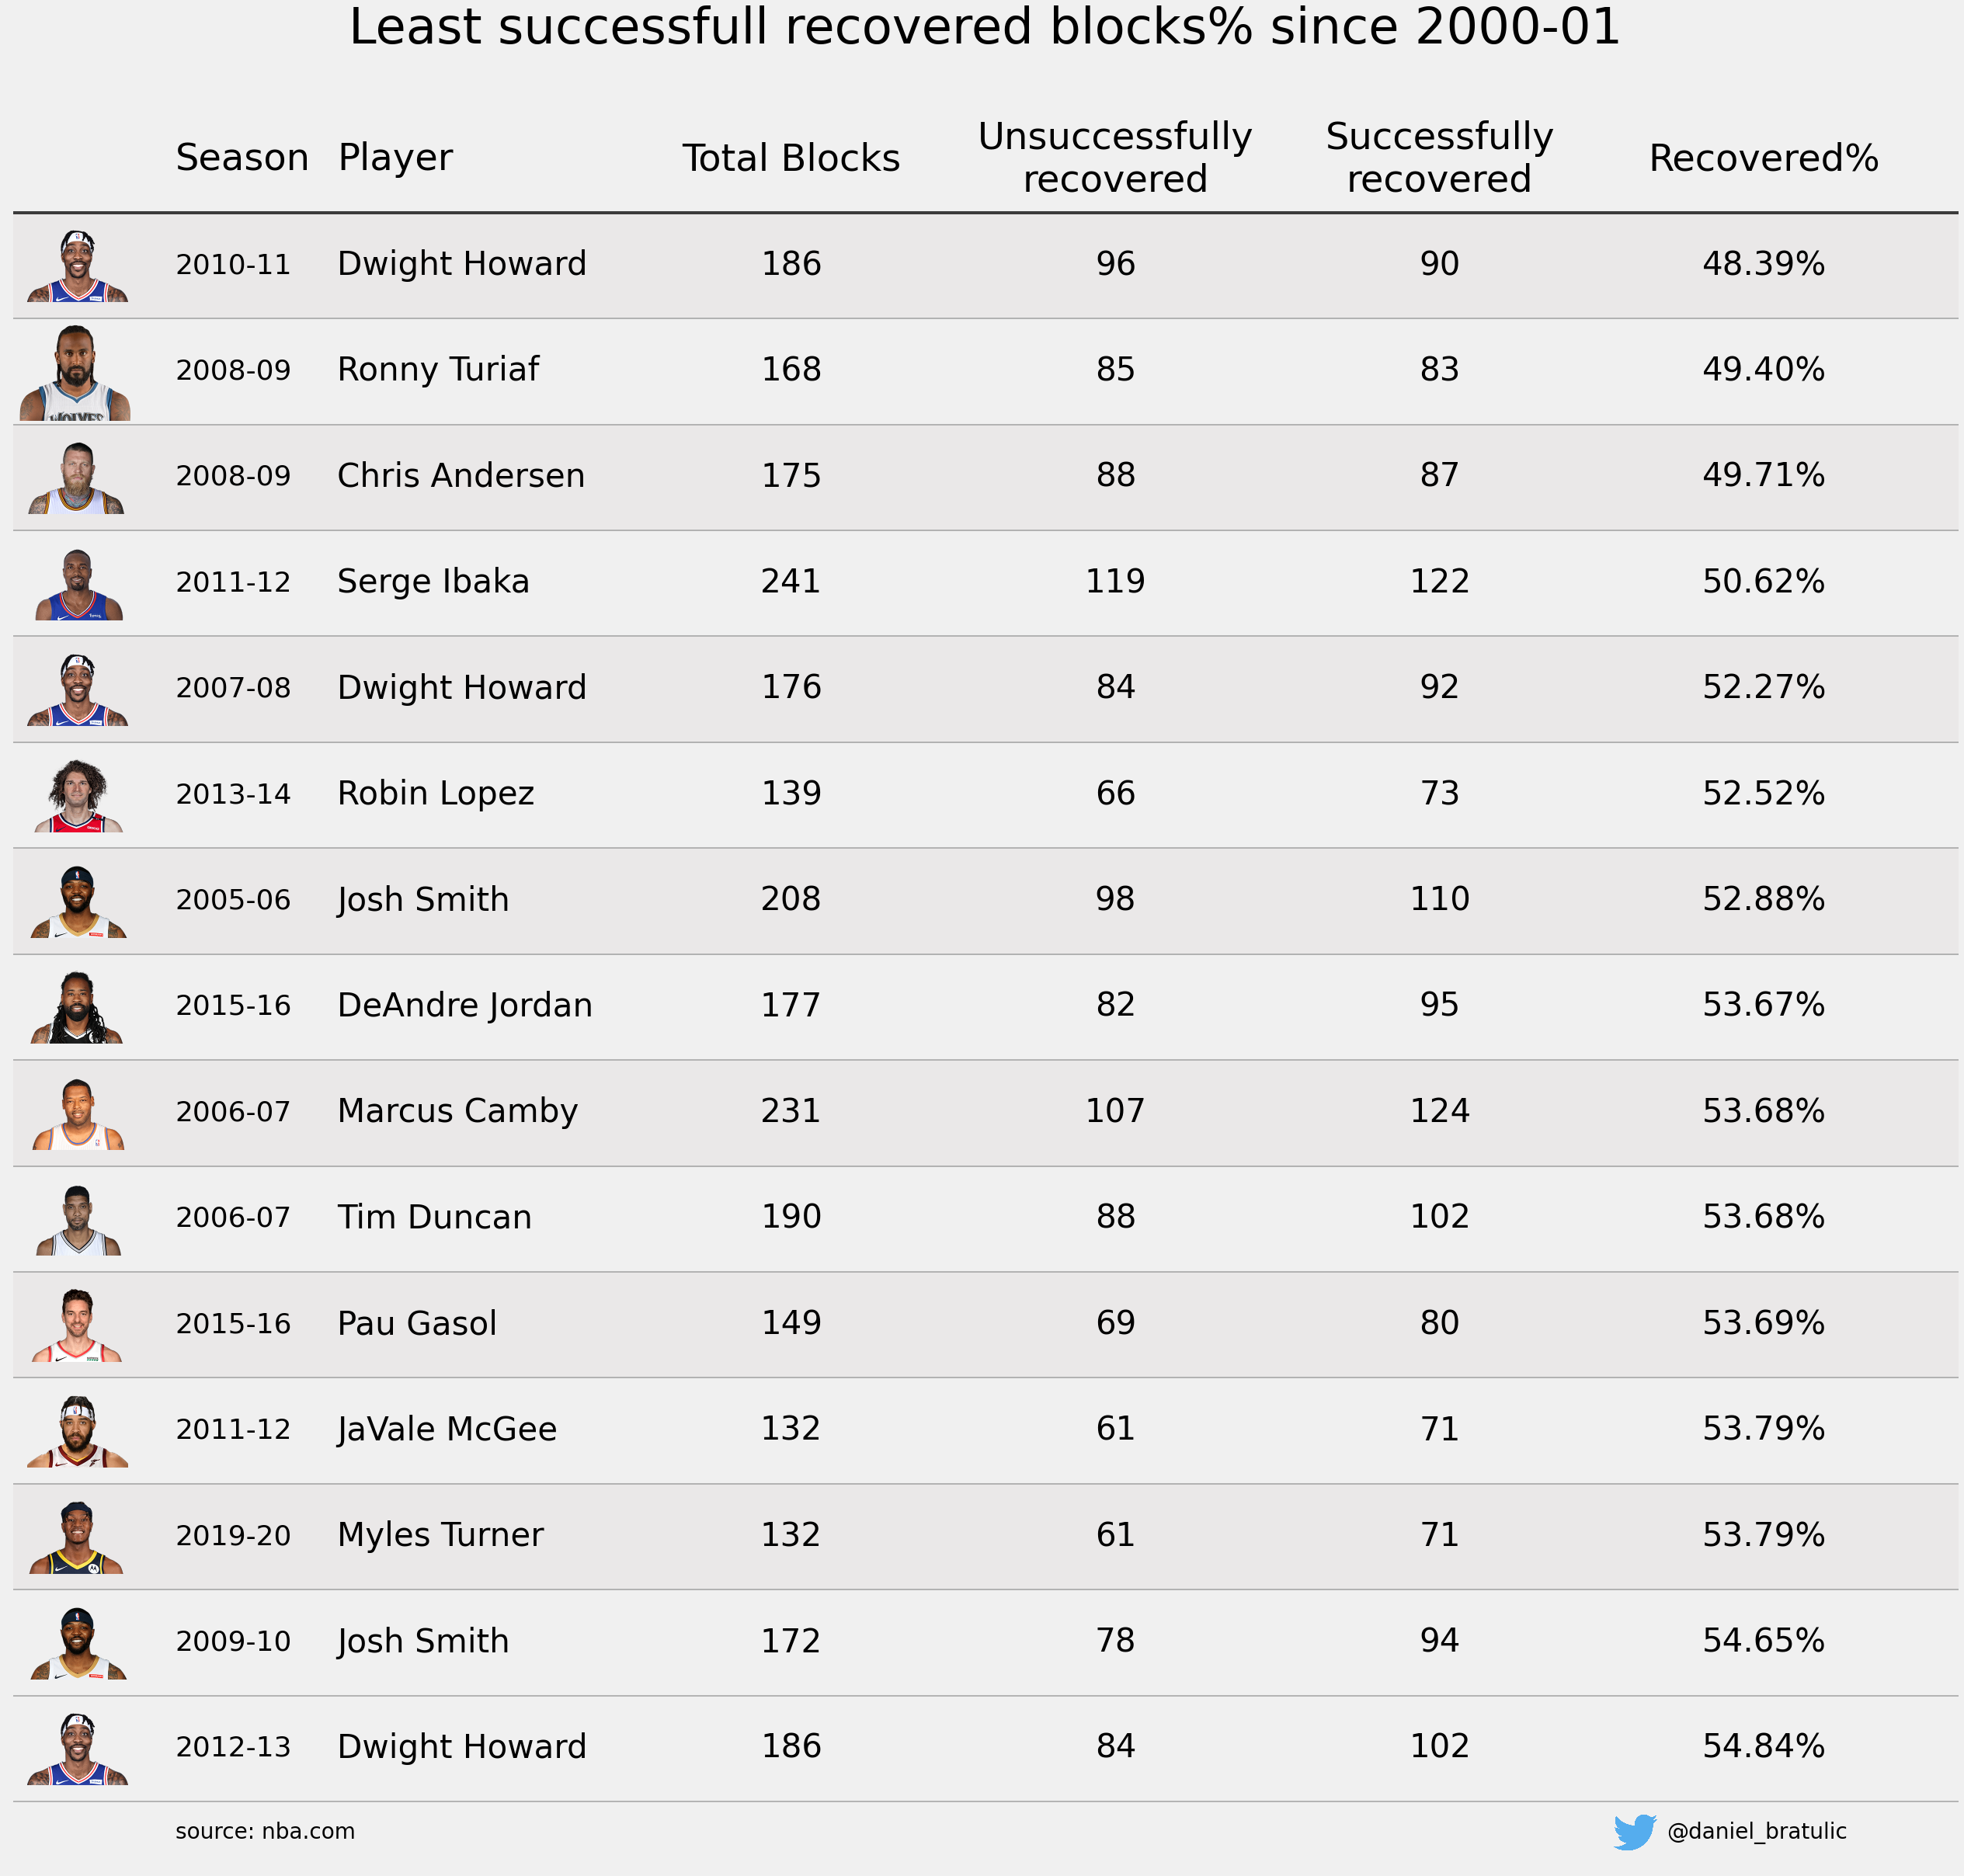

In [104]:
fig, ax = plt.subplots(figsize=(40, 40))
number_size = 42
font_size = 36
font_title = 48
title_size = 64
#top = 10

sorted_open_df = least_efficient
top = len(least_efficient)
for i in range(top):
    item = least_efficient.iloc[i] 
    try:
        player_id = find_players_by_full_name(item.PLAYER3_NAME_BLK)[0]['id']
        print(player_id)
    except Exception:
        continue
    y_coord = top - i - 1
    if i % 2 == 1:
        color = '#EAE8E8'
        rect = Rectangle((-4.5, y_coord + 0.5), width=15, height=1, fill=True, color=color)
        ax.add_patch(rect)
    
    ab = AnnotationBbox(get_player_img(player_id), (0.1, y_coord), frameon=False)
    ax.add_artist(ab)
    ax.text(x=0.25, y=y_coord, ha='left', va='center', s=item.SEASON, size=font_size)
    ax.text(x=0.5, y=y_coord, ha='left', va='center', s=item.PLAYER3_NAME_BLK, size=number_size)
    ax.axhline(y=y_coord-0.5, xmin=-0.25, xmax=10, color='#A0A0A0', alpha=0.75, lw=2)
    
    ax.text(x=1.2, y=y_coord, ha='center', va='center', s=f"{item.TOTAL}", size=number_size)
    ax.text(x=1.7, y=y_coord, ha='center', va='center', s=f"{item.UNSUCCESSFUL}", size=number_size)
    ax.text(x=2.2, y=y_coord, ha='center', va='center', s=f"{item.SUCCESSFUL}", size=number_size)
    ax.text(x=2.7, y=y_coord, ha='center', va='center', s=f"{item.SUCC_PCT:.2f}%", size=number_size)
    
    #y_img_start = y_coord-0.5 + (1 - 0.730769232) / 2
    #ax.imshow(img, extent=(0, 1.36, y_img_start-0.5, y_img_start + 0.1), aspect='auto')
    #ax.imshow(img, extent=(0, 260, 0, 190), aspect=260/190)
    
ax.text(x=0.25, y=top, s='Season', ha='left', va='center', size=font_title)
ax.text(x=0.5, y=top, s='Player', ha='left', va='center', size=font_title)
ax.text(x=1.2, y=top, ha='center', va='center', s="Total Blocks", size=font_title)
ax.text(x=1.7, y=top, ha='center', va='center', s="Unsuccessfully\nrecovered", size=font_title)
ax.text(x=2.2, y=top, ha='center', va='center', s="Successfully\nrecovered", size=font_title)
ax.text(x=2.7, y=top, ha='center', va='center', s="Recovered%", size=font_title)

#ax.text(x=2.75, y=-0.75, s='twitter: @daniel_bratulic', ha='right', va='center', size=30)
#ax.text(x=0.25, y=-0.75, s='data: nba.com', ha='left', va='center', size=30)
ax.axhline(y=top-0.5, xmin=-0.25, xmax=10, color='black', alpha=0.75, lw=4)
ax.set_title("Least successfull recovered blocks% since 2000-01", size=title_size)
    
ax.set_ylim(bottom=-1.1, top=top+1)
ax.set_xlim(left=-0, right=3)
ax.grid(False)
ax.set_frame_on(False)
ax.set_yticklabels([])
ax.set_xticklabels([])
ab = AnnotationBbox(OffsetImage(plt.imread(f'../../twitter_logo.png'), zoom=0.05), (2.5, -0.8), frameon=False)
ax.add_artist(ab)
ax.text(x=2.55, y=-0.85, ha='left', s='@daniel_bratulic', size=28)
ax.text(x=0.25, y=-0.85, ha='left', s='source: nba.com', size=28)
plt.savefig('block_recoveries.png', dpi=120, bbox_inches='tight')

## Most Efficient

297
87
201572
201586
101106
201586
979
203497
1905
201580
1502
203457
203497
203991
1495


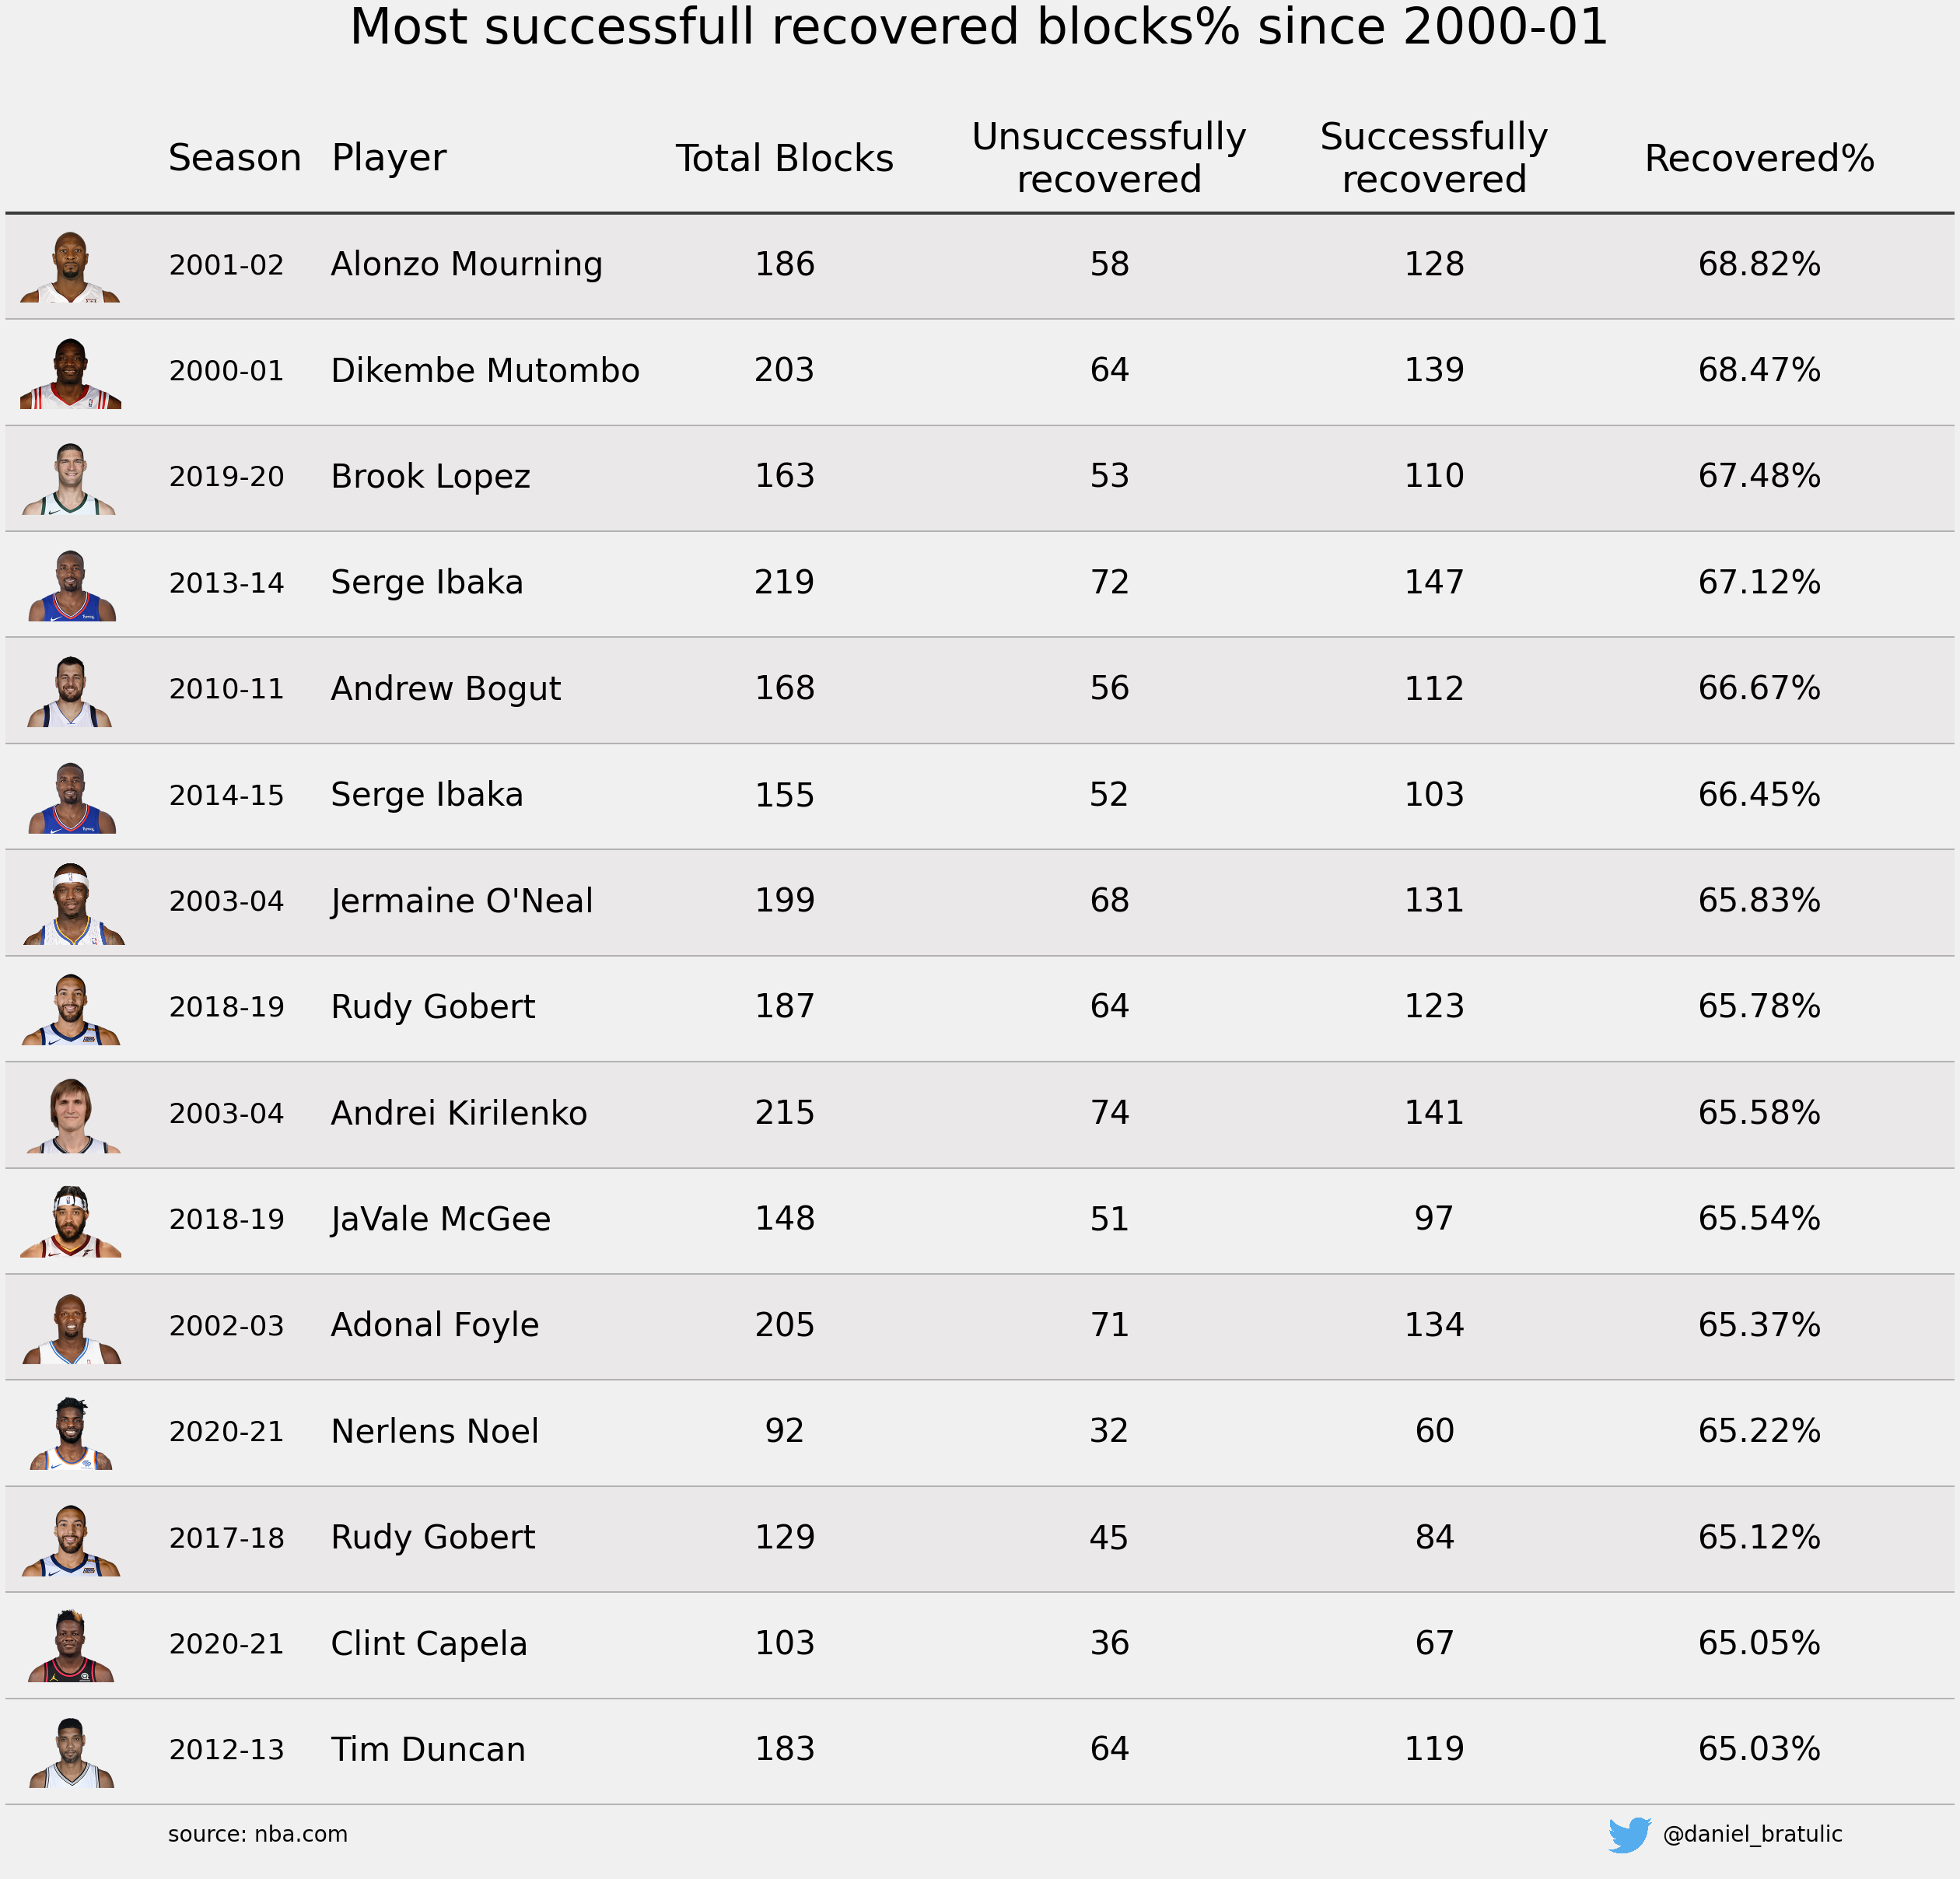

In [109]:
fig, ax = plt.subplots(figsize=(40, 40))
number_size = 42
font_size = 36
font_title = 48
title_size = 64
#top = 10

sorted_open_df = most_efficient
top = len(most_efficient)
for i in range(top):
    item = most_efficient.iloc[i] 
    try:
        player_id = find_players_by_full_name(item.PLAYER3_NAME_BLK)[0]['id']
        print(player_id)
    except Exception:
        continue
    y_coord = top - i - 1
    if i % 2 == 1:
        color = '#EAE8E8'
        rect = Rectangle((-4.5, y_coord + 0.5), width=15, height=1, fill=True, color=color)
        ax.add_patch(rect)
    
    zoom = 0.5
    if player_id == 979:
        zoom = 0.25
    ab = AnnotationBbox(get_player_img(player_id, zoom=zoom), (0.1, y_coord), frameon=False)
    ax.add_artist(ab)
    ax.text(x=0.25, y=y_coord, ha='left', va='center', s=item.SEASON, size=font_size)
    ax.text(x=0.5, y=y_coord, ha='left', va='center', s=item.PLAYER3_NAME_BLK, size=number_size)
    ax.axhline(y=y_coord-0.5, xmin=-0.25, xmax=10, color='#A0A0A0', alpha=0.75, lw=2)
    
    ax.text(x=1.2, y=y_coord, ha='center', va='center', s=f"{item.TOTAL}", size=number_size)
    ax.text(x=1.7, y=y_coord, ha='center', va='center', s=f"{item.UNSUCCESSFUL}", size=number_size)
    ax.text(x=2.2, y=y_coord, ha='center', va='center', s=f"{item.SUCCESSFUL}", size=number_size)
    ax.text(x=2.7, y=y_coord, ha='center', va='center', s=f"{item.SUCC_PCT:.2f}%", size=number_size)
    
    #y_img_start = y_coord-0.5 + (1 - 0.730769232) / 2
    #ax.imshow(img, extent=(0, 1.36, y_img_start-0.5, y_img_start + 0.1), aspect='auto')
    #ax.imshow(img, extent=(0, 260, 0, 190), aspect=260/190)
    
ax.text(x=0.25, y=top, s='Season', ha='left', va='center', size=font_title)
ax.text(x=0.5, y=top, s='Player', ha='left', va='center', size=font_title)
ax.text(x=1.2, y=top, ha='center', va='center', s="Total Blocks", size=font_title)
ax.text(x=1.7, y=top, ha='center', va='center', s="Unsuccessfully\nrecovered", size=font_title)
ax.text(x=2.2, y=top, ha='center', va='center', s="Successfully\nrecovered", size=font_title)
ax.text(x=2.7, y=top, ha='center', va='center', s="Recovered%", size=font_title)

#ax.text(x=2.75, y=-0.75, s='twitter: @daniel_bratulic', ha='right', va='center', size=30)
#ax.text(x=0.25, y=-0.75, s='data: nba.com', ha='left', va='center', size=30)
ax.axhline(y=top-0.5, xmin=-0.25, xmax=10, color='black', alpha=0.75, lw=4)
ax.set_title("Most successfull recovered blocks% since 2000-01", size=title_size)
    
ax.set_ylim(bottom=-1.1, top=top+1)
ax.set_xlim(left=-0, right=3)
ax.grid(False)
ax.set_frame_on(False)
ax.set_yticklabels([])
ax.set_xticklabels([])
ab = AnnotationBbox(OffsetImage(plt.imread(f'../../twitter_logo.png'), zoom=0.05), (2.5, -0.8), frameon=False)
ax.add_artist(ab)
ax.text(x=2.55, y=-0.85, ha='left', s='@daniel_bratulic', size=28)
ax.text(x=0.25, y=-0.85, ha='left', s='source: nba.com', size=28)
plt.savefig('block_recoveries.png', dpi=120, bbox_inches='tight')

## DPOY

In [81]:
combinations = [
    ('Dikembe Mutombo', '2000-01'),
    ('Ben Wallace', '2001-02'),
    ('Ben Wallace', '2002-03'),
    ('Ron Artest', '2003-04'),
    ('Ben Wallace', '2004-05'),
    ('Ben Wallace', '2005-06'),
    ('Marcus Camby', '2006-07'),
    ('Kevin Garnett', '2007-08'),
    ('Dwight Howard', '2008-09'),
    ('Dwight Howard', '2009-10'),
    ('Dwight Howard', '2010-11'),
    ('Tyson Chandler', '2011-12'),
    ('Marc Gasol', '2012-13'),
    ('Joakim Noah', '2013-14'),
    ('Kawhi Leonard', '2014-15'),
    ('Kawhi Leonard', '2015-16'),
    ('Draymond Green', '2016-17'),
    ('Rudy Gobert', '2017-18'),
    ('Rudy Gobert', '2018-19'),
    ('Giannis Antetokounmpo', '2019-20'),
]

In [ ]:

per_season_data = []

In [125]:
dpoys = []
for player, season in combinations:
    print(season)
    if player == "Ron Artest":
        player_id = find_players_by_full_name("Metta World Peace")[0]['id']
    else:
        player_id = find_players_by_full_name(player)[0]['id']
    pbp_df = pd.read_csv(f'pbp_analysis/pbp_data/{season}.csv')
    pbp_df = pbp_df.fillna({
        "HOMEDESCRIPTION": "",
        "NEUTRALDESCRIPTION": "",
        "VISITORDESCRIPTION": ""
    })
    pbp_df.loc[:, 'GAME_ID'] = [f"00{item}" for item in pbp_df.GAME_ID.astype(str)]
    blocked_shots = pbp_df.loc[(pbp_df.HOMEDESCRIPTION.str.contains("BLK")) | (pbp_df.VISITORDESCRIPTION.str.contains("BLK"))]
    
    #player_stats = LeagueDashPlayerStats(season=season, per_mode_detailed='Totals').get_data_frames()[0]
    #top_blockers = player_stats.sort_values(by='BLK', ascending=False).iloc[:5]
    blocked_shots = blocked_shots.loc[blocked_shots.PLAYER3_ID == player_id]
    next_events = []
    for index in tqdm.tqdm(range(len(blocked_shots))):
        item = blocked_shots.iloc[index]
        next_item = pbp_df.iloc[pbp_df.loc[(pbp_df.GAME_ID == item.GAME_ID) & (pbp_df.EVENTNUM == item.EVENTNUM)].iloc[0].name+1]
        next_events.append(next_item.EVENTNUM)
    
    blocked_shots.loc[:, 'NEXT_EVENTNUM'] = next_events
    merged_blocks = pd.merge(left=blocked_shots, right=pbp_df, left_on=('GAME_ID', 'NEXT_EVENTNUM'), right_on=('GAME_ID', 'EVENTNUM'), suffixes=('_BLK', '_NEXT'))
    #player_stats = LeagueDashPlayerStats(season=season, per_mode_detailed='Totals').get_data_frames()[0]
    #top_blockers = player_stats.sort_values(by='BLK', ascending=False).iloc[:10]
    merged_blocks.PLAYER3_TEAM_ID_BLK = merged_blocks.PLAYER3_TEAM_ID_BLK.astype('str')
    merged_blocks.PLAYER1_TEAM_ID_NEXT = merged_blocks.PLAYER1_TEAM_ID_NEXT.astype('str')
    #print(merged_blocks)
    reformatted_dfs = []
    for index in [0]:
        player_blocks = merged_blocks.loc[merged_blocks.PLAYER3_ID_BLK == player_id]
        is_successful = []
        for cur_index in range(len(player_blocks)):
            block_item = player_blocks.iloc[cur_index]
            if block_item.PLAYER1_TEAM_ID_NEXT == 'nan':
                if str(block_item.PLAYER1_ID_NEXT) == str(block_item.PLAYER3_TEAM_ID_BLK).split(".")[0]:
                    is_successful.append(1)
                else:
                    is_successful.append(0)
            else:
                if str(block_item.PLAYER1_TEAM_ID_NEXT) == str(block_item.PLAYER3_TEAM_ID_BLK):
                    is_successful.append(1)
                else:
                    is_successful.append(0)
        player_blocks.loc[:, 'SUCCESSFUL'] = is_successful
        reformatted_dfs.append(player_blocks)
    concat_top_blockers = pd.concat(reformatted_dfs)

    group_top = concat_top_blockers.groupby('PLAYER3_NAME_BLK').SUCCESSFUL.value_counts().unstack(level=1).reset_index()
    renamed_group = group_top.rename(
        columns={
            0: 'UNSUCCESSFUL',
            1: 'SUCCESSFUL'
        }
    )
    renamed_group.loc[:, 'TOTAL'] = renamed_group.UNSUCCESSFUL + renamed_group.SUCCESSFUL
    renamed_group.loc[:, 'SUCC_PCT'] = renamed_group.SUCCESSFUL / renamed_group.TOTAL * 100
    renamed_group.loc[:, 'SEASON'] = season
    renamed_group.loc[:, 'GP'] = top_blockers.GP
    #item = full_data.loc[(full_data.PLAYER3_NAME_BLK == player) & (full_data.SEASON == season)]
    #if len(item) > 0:
    dpoys.append(renamed_group)

2000-01



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:07<00:00, 28.75it/s]


2001-02



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:09<00:00, 30.12it/s]


2002-03



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:07<00:00, 29.47it/s]


2003-04



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 29.84it/s]


2004-05



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 176/176 [00:06<00:00, 28.47it/s]


2005-06



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 181/181 [00:06<00:00, 28.49it/s]


2006-07



 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 225/231 [00:07<00:00, 28.25it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 231/231 [00:08<00:00, 28.15it/s]


2007-08



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 89/89 [00:03<00:00, 28.57it/s]


2008-09



 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 227/231 [00:07<00:00, 28.77it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 231/231 [00:08<00:00, 28.53it/s]


2009-10



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 228/228 [00:08<00:00, 28.32it/s]


2010-11



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 186/186 [00:06<00:00, 28.30it/s]


2011-12



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 89/89 [00:02<00:00, 35.22it/s]


2012-13



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:04<00:00, 27.85it/s]


2013-14



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 121/121 [00:04<00:00, 27.98it/s]


2014-15



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 27.69it/s]


2015-16



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:02<00:00, 27.31it/s]


2016-17



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:03<00:00, 27.48it/s]


2017-18



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 129/129 [00:04<00:00, 27.77it/s]


2018-19



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 187/187 [00:07<00:00, 26.58it/s]


2019-20



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66/66 [00:02<00:00, 30.06it/s]


In [126]:
dpoy_df = pd.concat(dpoys)

In [127]:
dpoy_df

SUCCESSFUL       PLAYER3_NAME_BLK  UNSUCCESSFUL  SUCCESSFUL  TOTAL   SUCC_PCT  \
0                 Dikembe Mutombo            64         139    203  68.472906   
0                     Ben Wallace           123         155    278  55.755396   
0                     Ben Wallace            96         134    230  58.260870   
0               Metta World Peace            17          33     50  66.000000   
0                     Ben Wallace            78          98    176  55.681818   
0                     Ben Wallace            74         107    181  59.116022   
0                    Marcus Camby           107         124    231  53.679654   
0                   Kevin Garnett            36          53     89  59.550562   
0                   Dwight Howard           103         128    231  55.411255   
0                   Dwight Howard            90         138    228  60.526316   
0                   Dwight Howard            96          90    186  48.387097   
0                  Tyson Chandler            37          52     89  58.426966   
0                      Marc Gasol            69          70    139  50.359712   
0                     Joakim Noah            45          76    121  62.809917   
0                   Kawhi Leonard            23          25     48  52.083333   
0                   Kawhi Leonard            26          45     71  63.380282   
0                  Draymond Green            46          60    106  56.603774   
0                     Rudy Gobert            45          84    129  65.116279   
0                     Rudy Gobert            64         123    187  65.775401   
0           Giannis Antetokounmpo            25          41     66  62.121212   

SUCCESSFUL   SEASON  GP  
0           2000-01 NaN  
0           2001-02 NaN  
0           2002-03 NaN  
0           2003-04 NaN  
0           2004-05 NaN  
0           2005-06 NaN  
0           2006-07 NaN  
0           2007-08 NaN  
0           2008-09 NaN  
0           2009-10 NaN  
0           2010-11 NaN  
0           2011-12 NaN  
0           2012-13 NaN  
0           2013-14 NaN  
0           2014-15 NaN  
0           2015-16 NaN  
0           2016-17 NaN  
0           2017-18 NaN  
0           2018-19 NaN  
0           2019-20 NaN

In [128]:
dpoy_df = dpoy_df.sort_values(by='SUCC_PCT', ascending=False)

87
1897
203497
203497
202695
201149
203507
2730
708
1112
2199
1112
203110
1112
1112
2730
948
202695
201188
2730


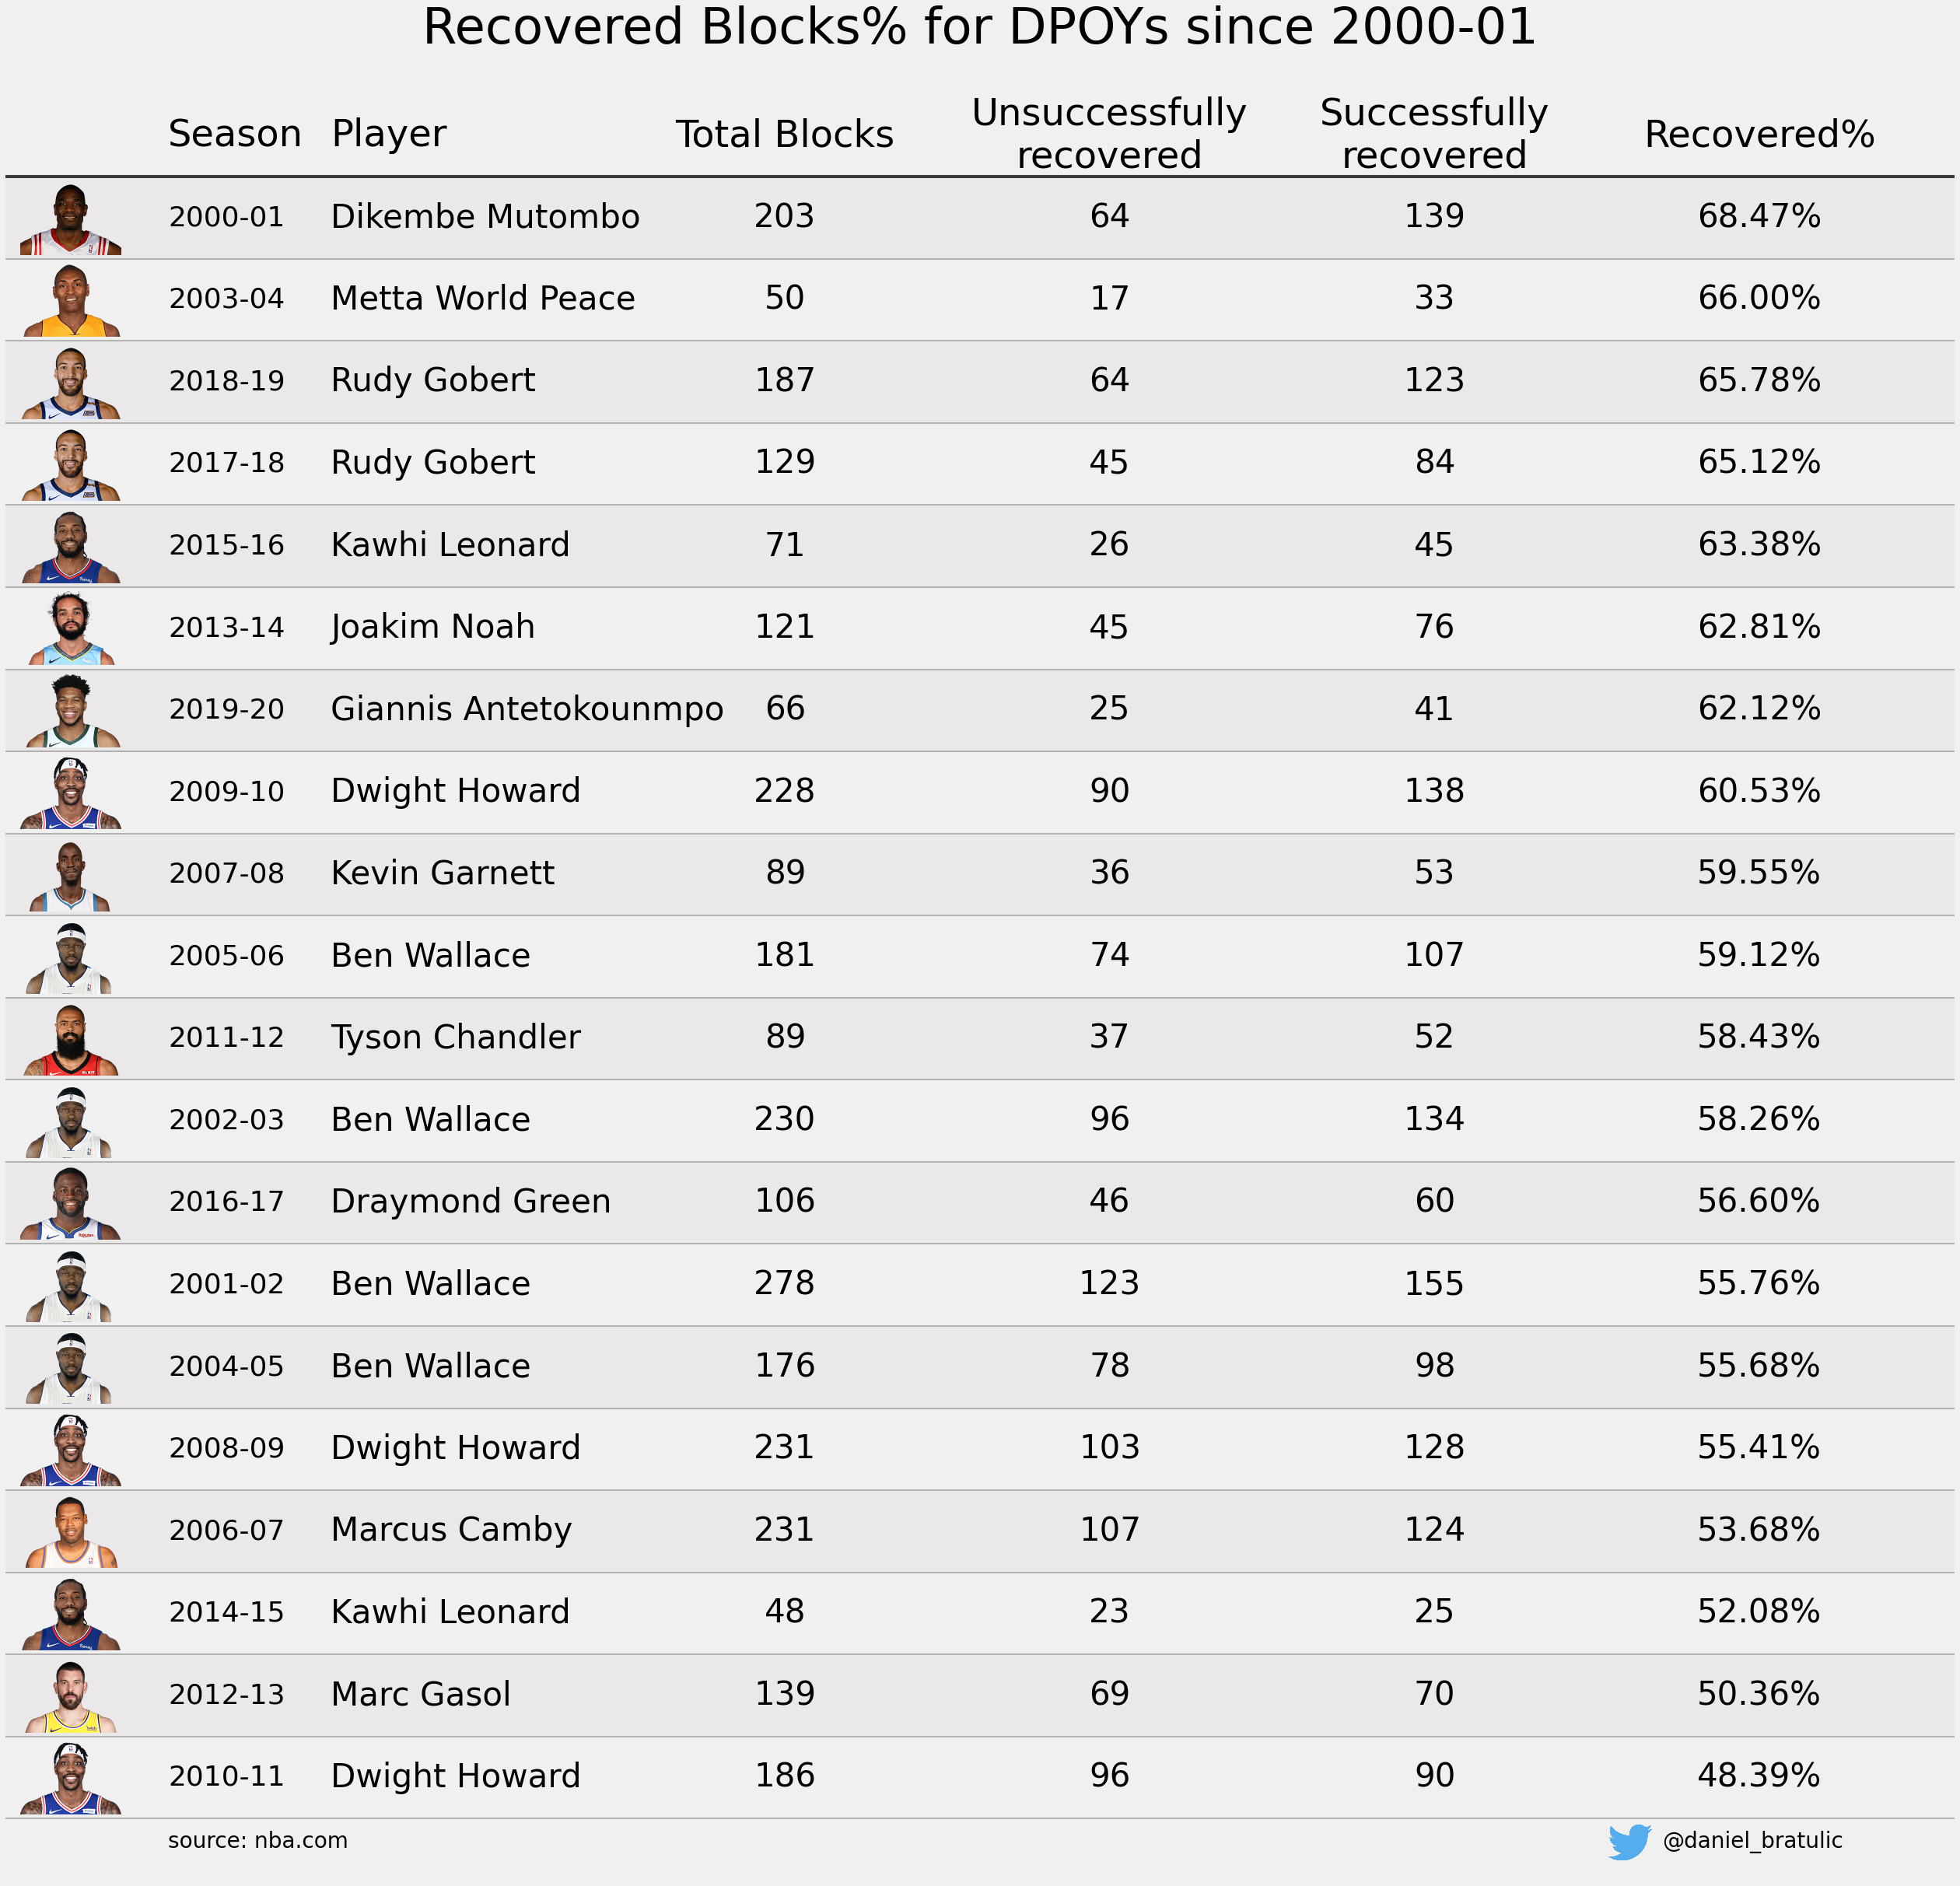

In [131]:
fig, ax = plt.subplots(figsize=(40, 40))
number_size = 42
font_size = 36
font_title = 48
title_size = 64
#top = 10

sorted_open_df = dpoy_df
top = len(dpoy_df)
for i in range(top):
    item = dpoy_df.iloc[i] 
    try:
        player_id = find_players_by_full_name(item.PLAYER3_NAME_BLK)[0]['id']
        print(player_id)
    except Exception:
        continue
    y_coord = top - i - 1
    if i % 2 == 1:
        color = '#EAE8E8'
        rect = Rectangle((-4.5, y_coord + 0.5), width=15, height=1, fill=True, color=color)
        ax.add_patch(rect)
    
    zoom = 0.5
    if player_id == 979:
        zoom = 0.25
    ab = AnnotationBbox(get_player_img(player_id, zoom=zoom), (0.1, y_coord), frameon=False)
    ax.add_artist(ab)
    ax.text(x=0.25, y=y_coord, ha='left', va='center', s=item.SEASON, size=font_size)
    ax.text(x=0.5, y=y_coord, ha='left', va='center', s=item.PLAYER3_NAME_BLK, size=number_size)
    ax.axhline(y=y_coord-0.5, xmin=-0.25, xmax=10, color='#A0A0A0', alpha=0.75, lw=2)
    
    ax.text(x=1.2, y=y_coord, ha='center', va='center', s=f"{item.TOTAL}", size=number_size)
    ax.text(x=1.7, y=y_coord, ha='center', va='center', s=f"{item.UNSUCCESSFUL}", size=number_size)
    ax.text(x=2.2, y=y_coord, ha='center', va='center', s=f"{item.SUCCESSFUL}", size=number_size)
    ax.text(x=2.7, y=y_coord, ha='center', va='center', s=f"{item.SUCC_PCT:.2f}%", size=number_size)
    
    #y_img_start = y_coord-0.5 + (1 - 0.730769232) / 2
    #ax.imshow(img, extent=(0, 1.36, y_img_start-0.5, y_img_start + 0.1), aspect='auto')
    #ax.imshow(img, extent=(0, 260, 0, 190), aspect=260/190)
    
ax.text(x=0.25, y=top, s='Season', ha='left', va='center', size=font_title)
ax.text(x=0.5, y=top, s='Player', ha='left', va='center', size=font_title)
ax.text(x=1.2, y=top, ha='center', va='center', s="Total Blocks", size=font_title)
ax.text(x=1.7, y=top, ha='center', va='center', s="Unsuccessfully\nrecovered", size=font_title)
ax.text(x=2.2, y=top, ha='center', va='center', s="Successfully\nrecovered", size=font_title)
ax.text(x=2.7, y=top, ha='center', va='center', s="Recovered%", size=font_title)

#ax.text(x=2.75, y=-0.75, s='twitter: @daniel_bratulic', ha='right', va='center', size=30)
#ax.text(x=0.25, y=-0.75, s='data: nba.com', ha='left', va='center', size=30)
ax.axhline(y=top-0.5, xmin=-0.25, xmax=10, color='black', alpha=0.75, lw=4)
ax.set_title("Recovered Blocks% for DPOYs since 2000-01", size=title_size)
    
ax.set_ylim(bottom=-1.1, top=top+1)
ax.set_xlim(left=-0, right=3)
ax.grid(False)
ax.set_frame_on(False)
ax.set_yticklabels([])
ax.set_xticklabels([])
ab = AnnotationBbox(OffsetImage(plt.imread(f'../../twitter_logo.png'), zoom=0.05), (2.5, -0.8), frameon=False)
ax.add_artist(ab)
ax.text(x=2.55, y=-0.85, ha='left', s='@daniel_bratulic', size=28)
ax.text(x=0.25, y=-0.85, ha='left', s='source: nba.com', size=28)
plt.savefig('block_recoveries.png', dpi=120, bbox_inches='tight')

## Rim Deterrence

In [7]:
shotchart_all = ShotChartDetail(player_id=0, team_id=0, context_measure_simple='FGA', season_nullable='2021-22', timeout=900).get_data_frames()[0]

shotchart_all.LOC_X = -shotchart_all.LOC_X

In [8]:
full_df = pd.read_csv('pbp_analysis/pbp_players/2020-21.csv')
#formatted_df.loc[:, 'GAME_ID'] = [f"00{item}" for item in formatted_df.GAME_ID.astype(str)]

In [9]:
full_df.loc[:, "PCTIMESECONDS"] = [720 - (int(item.PCTIMESTRING.split(":")[0]) * 60 + int(item.PCTIMESTRING.split(":")[1])) if item.PERIOD < 5 else 300 - (int(item.PCTIMESTRING.split(":")[0]) * 60 + int(item.PCTIMESTRING.split(":")[1])) for index, item in full_df.iterrows()]

full_df = full_df.fillna({
    "HOMEDESCRIPTION": "",
    "NEUTRALDESCRIPTION": "",
    "VISITORDESCRIPTION": ""
})

In [10]:
full_df.loc[:, 'GAME_ID'] = [f"00{item}" for item in full_df.GAME_ID.astype(str)]

In [11]:
player_teams = {
    'Rudy Gobert': 'Utah Jazz',
    'Myles Turner': 'Indiana Pacers',
    #'Anthony Davis': 'Los Angeles Lakers',
    'Joel Embiid': 'Philadelphia 76ers',
    'Giannis Antetokounmpo': 'Milwaukee Bucks',
    'Brook Lopez': 'Milwaukee Bucks',
    'DeAndre Ayton': 'Phoenix Suns',
    'Nikola Jokic': 'Denver Nuggets',
    'Christian Wood': 'Houston Rockets',
    'Kristaps Porzingis': 'Dallas Mavericks',
    #'Mitchell Robinson': 'New York Knicks',
    #'Robert Williams III': 'Boston Celtics',
    'DeAndre Jordan': 'Brooklyn Nets',
    'Jakob Poeltl': 'San Antonio Spurs',
    'Richaun Holmes': 'Sacramento Kings'
}

In [12]:
target_player_columns = [
    'TEAM_1_PLAYER_1', 'TEAM_1_PLAYER_2', 'TEAM_1_PLAYER_3',
    'TEAM_1_PLAYER_4', 'TEAM_1_PLAYER_5', 'TEAM_2_PLAYER_1',
    'TEAM_2_PLAYER_2', 'TEAM_2_PLAYER_3', 'TEAM_2_PLAYER_4',
    'TEAM_2_PLAYER_5'
]

def get_on_floor(player_id, df):
    queries = [df[key] == player_id for key in target_player_columns]
    query = queries[0]
    for cur in queries[1:]:
        query = query | cur
    return df.loc[query]


def get_off_floor(player_id, df):
    queries = [df[key] != player_id for key in target_player_columns]
    query = queries[0]
    for cur in queries[1:]:
        query = query & cur
    return df.loc[query]


def check_any(item, player_id):
    for col in target_player_columns:
        if item[col] == player_id:
            return True
    return False


In [237]:
#key = ['SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'SHOT_ZONE_BASIC']
key = ['SHOT_ZONE_BASIC']

defense_dfs = {}

for player in player_teams:
    pl_id = find_players_by_full_name(player)[0]['id']
    team_id = find_teams_by_full_name(player_teams[player])[0]['id']
    
    player_on_floor = get_on_floor(pl_id, full_df)
    player_off_floor = get_off_floor(pl_id, full_df)
    player_off_floor = player_off_floor.loc[player_off_floor.GAME_ID.isin(player_on_floor.GAME_ID.unique())]

    shot_off_court = pd.merge(left=shotchart_all, right=player_off_floor, left_on=('GAME_ID', 'GAME_EVENT_ID'), right_on=('GAME_ID', 'EVENTNUM'))
    shot_on_court = pd.merge(left=shotchart_all, right=player_on_floor, left_on=('GAME_ID', 'GAME_EVENT_ID'), right_on=('GAME_ID', 'EVENTNUM'))
    
    non_team_on_court = shot_on_court.loc[shot_on_court.TEAM_ID != team_id]
    non_team_off_court = shot_off_court.loc[shot_off_court.TEAM_ID != team_id]
    
    
    grouped_off = non_team_off_court.groupby(key).sum().reset_index()
    grouped_off = grouped_off.loc[:, key + ['SHOT_MADE_FLAG', 'SHOT_ATTEMPTED_FLAG']]
    grouped_off.loc[:, 'FG_PCT'] = grouped_off.SHOT_MADE_FLAG / grouped_off.SHOT_ATTEMPTED_FLAG * 100
    grouped_off.loc[:, 'PCT_OF_SHOTS'] = grouped_off.SHOT_ATTEMPTED_FLAG / grouped_off.SHOT_ATTEMPTED_FLAG.sum() * 100

    grouped_on = non_team_on_court.groupby(key).sum().reset_index()
    grouped_on = grouped_on.loc[:, key + ['SHOT_MADE_FLAG', 'SHOT_ATTEMPTED_FLAG']]
    grouped_on.loc[:, 'FG_PCT'] = grouped_on.SHOT_MADE_FLAG / grouped_on.SHOT_ATTEMPTED_FLAG * 100
    grouped_on.loc[:, 'PCT_OF_SHOTS'] = grouped_on.SHOT_ATTEMPTED_FLAG / grouped_on.SHOT_ATTEMPTED_FLAG.sum() * 100
    
    merged_defender_df = pd.merge(left=grouped_on, right=grouped_off, on=key, suffixes=('_ON', '_OFF'))
    defense_dfs[player] = merged_defender_df

In [253]:
df.SHOT_ZONE_BASIC.unique()

array(['Above the Break 3', 'Backcourt', 'In The Paint (Non-RA)',
       'Left Corner 3', 'Mid-Range', 'Restricted Area', 'Right Corner 3'],
      dtype=object)

In [254]:
mappings = {
    'Above the Break 3': 'ATB_3',
    'In The Paint (Non-RA)': 'PAINT',
    'Corner 3': 'CORNER',
    'Mid-Range': 'MID',
    'Restricted Area': 'RA',
}

In [265]:
print_data = []

for player in defense_dfs:
    df = defense_dfs[player]
    cur_dict = {
        'PLAYER': player
    }
    for key in mappings:
        if key == 'Corner 3':
            cur_df = df.loc[(df.SHOT_ZONE_BASIC == 'Left Corner 3') | (df.SHOT_ZONE_BASIC == 'Right Corner 3')].iloc[0]
        else:
            cur_df = df.loc[df.SHOT_ZONE_BASIC == key].iloc[0]
        value = mappings[key]
        cur_dict[f"{value}_FG_RATE_ON"] = round(cur_df.PCT_OF_SHOTS_ON, 2)
        cur_dict[f"{value}_FG_RATE_OFF"] = round(cur_df.PCT_OF_SHOTS_OFF, 2)
        cur_dict[f"{value}_FG_RATE_DIFF"] = round(cur_df.PCT_OF_SHOTS_ON - cur_df.PCT_OF_SHOTS_OFF, 2)
        cur_dict[f"{value}_FG_PCT_ON"] = round(cur_df.FG_PCT_ON, 2)
        cur_dict[f"{value}_FG_PCT_OFF"] = round(cur_df.FG_PCT_OFF, 2)
        cur_dict[f"{value}_FG_PCT_DIFF"] = round(cur_df.FG_PCT_ON - cur_df.FG_PCT_OFF, 2)
    print_data.append(cur_dict)
    """paint = df.loc[df.SHOT_ZONE_BASIC == 'In The Paint (Non-RA)'].iloc[0]
    ra = df.loc[df.SHOT_ZONE_BASIC == 'Restricted Area'].iloc[0]
    mid = df.loc[df.SHOT_ZONE_BASIC == 'Mid-Range'].iloc[0]
    print_data.append(
        {
            'PLAYER': player,
            'RA_FG_RATE_ON': round(ra.PCT_OF_SHOTS_ON, 2),
            'RA_FG_RATE_OFF': round(ra.PCT_OF_SHOTS_OFF, 2),
            'RA_FG_RATE_DIFF': round(ra.PCT_OF_SHOTS_ON - ra.PCT_OF_SHOTS_OFF, 2),
            'RA_FG_PCT_ON': round(ra.FG_PCT_ON, 2),
            'RA_FG_PCT_OFF': round(ra.FG_PCT_OFF, 2),
            'RA_FG_PCT_DIFF': round(ra.FG_PCT_ON - ra.FG_PCT_OFF, 2),
            'PAINT_FG_PCT_DIFF': round(paint.FG_PCT_ON - paint.FG_PCT_OFF, 2),
            'MID_FG_PCT_DIFF': round(mid.FG_PCT_ON - mid.FG_PCT_OFF, 2),
            'PAINT_FG_RATE_DIFF': round(paint.PCT_OF_SHOTS_ON - paint.PCT_OF_SHOTS_OFF, 2),
            'MID_FG_RATE_DIFF': round(mid.PCT_OF_SHOTS_ON - mid.PCT_OF_SHOTS_OFF, 2),
        }
    )"""
    """
    print(f"RA FG% for {player}: {ra.FG_PCT_ON:.2f}")
    print(f"On-Off Diff in RA for {player}: {(ra.FG_PCT_ON - ra.FG_PCT_OFF):.2f}%; Rate: {(ra.PCT_OF_SHOTS_ON - ra.PCT_OF_SHOTS_OFF):.2f}%")
    print(f"On-Off Diff in Paint for {player}: {(paint.FG_PCT_ON - paint.FG_PCT_OFF):.2f}%; Rate: {(paint.PCT_OF_SHOTS_ON - paint.PCT_OF_SHOTS_OFF):.2f}%")
    print(f"On-Off Diff in Mid Range for {player}: {(mid.FG_PCT_ON - mid.FG_PCT_OFF):.2f}%; Rate: {(mid.PCT_OF_SHOTS_ON - mid.PCT_OF_SHOTS_OFF):.2f}%")
    print()
    """
print_df = pd.DataFrame(print_data)

In [266]:
ra_diff_sort = print_df.sort_values(by='RA_FG_RATE_DIFF')

In [267]:
ra_diff_sort

PLAYER  ATB_3_FG_RATE_ON  ATB_3_FG_RATE_OFF  \
0             Rudy Gobert             28.58              26.56   
9          DeAndre Jordan             28.97              30.16   
4             Brook Lopez             32.49              33.78   
6            Nikola Jokic             29.47              30.66   
10           Jakob Poeltl             28.09              28.51   
1            Myles Turner             25.53              25.63   
3   Giannis Antetokounmpo             32.22              34.44   
11         Richaun Holmes             28.46              26.27   
5           DeAndre Ayton             29.93              31.32   
7          Christian Wood             29.36              31.49   
2             Joel Embiid             30.80              31.65   
8      Kristaps Porzingis             31.33              34.39   

    ATB_3_FG_RATE_DIFF  ATB_3_FG_PCT_ON  ATB_3_FG_PCT_OFF  ATB_3_FG_PCT_DIFF  \
0                 2.02            33.99             33.55               0.44   
9                -1.19            39.28             34.73               4.55   
4                -1.30            37.63             35.08               2.55   
6                -1.19            37.17             28.14               9.03   
10               -0.43            37.59             36.08               1.51   
1                -0.11            34.73             39.20              -4.47   
3                -2.22            36.63             38.62              -1.98   
11                2.19            38.93             38.04               0.89   
5                -1.40            34.05             33.99               0.06   
7                -2.14            38.38             33.76               4.62   
2                -0.85            37.97             36.52               1.44   
8                -3.06            38.36             38.52              -0.17   

    PAINT_FG_RATE_ON  PAINT_FG_RATE_OFF  PAINT_FG_RATE_DIFF  ...  \
0              22.20              22.08                0.13  ...   
9              19.68              18.93                0.75  ...   
4              19.28              17.27                2.02  ...   
6              17.72              16.41                1.31  ...   
10             18.00              17.69                0.30  ...   
1              17.77              15.72                2.05  ...   
3              18.57              17.76                0.82  ...   
11             18.51              19.45               -0.94  ...   
5              18.08              18.31               -0.23  ...   
7              17.99              16.25                1.74  ...   
2              15.80              17.43               -1.63  ...   
8              15.69              14.25                1.44  ...   

    MID_FG_RATE_DIFF  MID_FG_PCT_ON  MID_FG_PCT_OFF  MID_FG_PCT_DIFF  \
0               3.57          39.15           37.07             2.08   
9               3.65          42.30           41.02             1.28   
4               1.10          43.85           42.00             1.85   
6               2.11          44.15           33.33            10.81   
10              1.08          42.11           44.93            -2.82   
1               1.33          38.59           35.20             3.40   
3               2.15          43.40           46.24            -2.84   
11             -0.18          40.58           36.24             4.33   
5               0.36          41.99           39.52             2.47   
7              -0.71          40.52           41.13            -0.61   
2               0.18          37.19           33.55             3.63   
8              -0.12          44.88           34.00            10.88   

    RA_FG_RATE_ON  RA_FG_RATE_OFF  RA_FG_RATE_DIFF  RA_FG_PCT_ON  \
0           26.01           32.29            -6.28         60.16   
9           27.26           30.12            -2.86         62.78   
4           24.18           26.27            -2.09         59.78   
6           27.45        

In [18]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import Rectangle
zoom = 0.5

player_root_dir = f'player_imgs/'

def get_player_img(player_id, zoom=0.5):
    #print(path)
    return OffsetImage(plt.imread(f'{player_root_dir}{player_id}.png'), zoom=zoom)


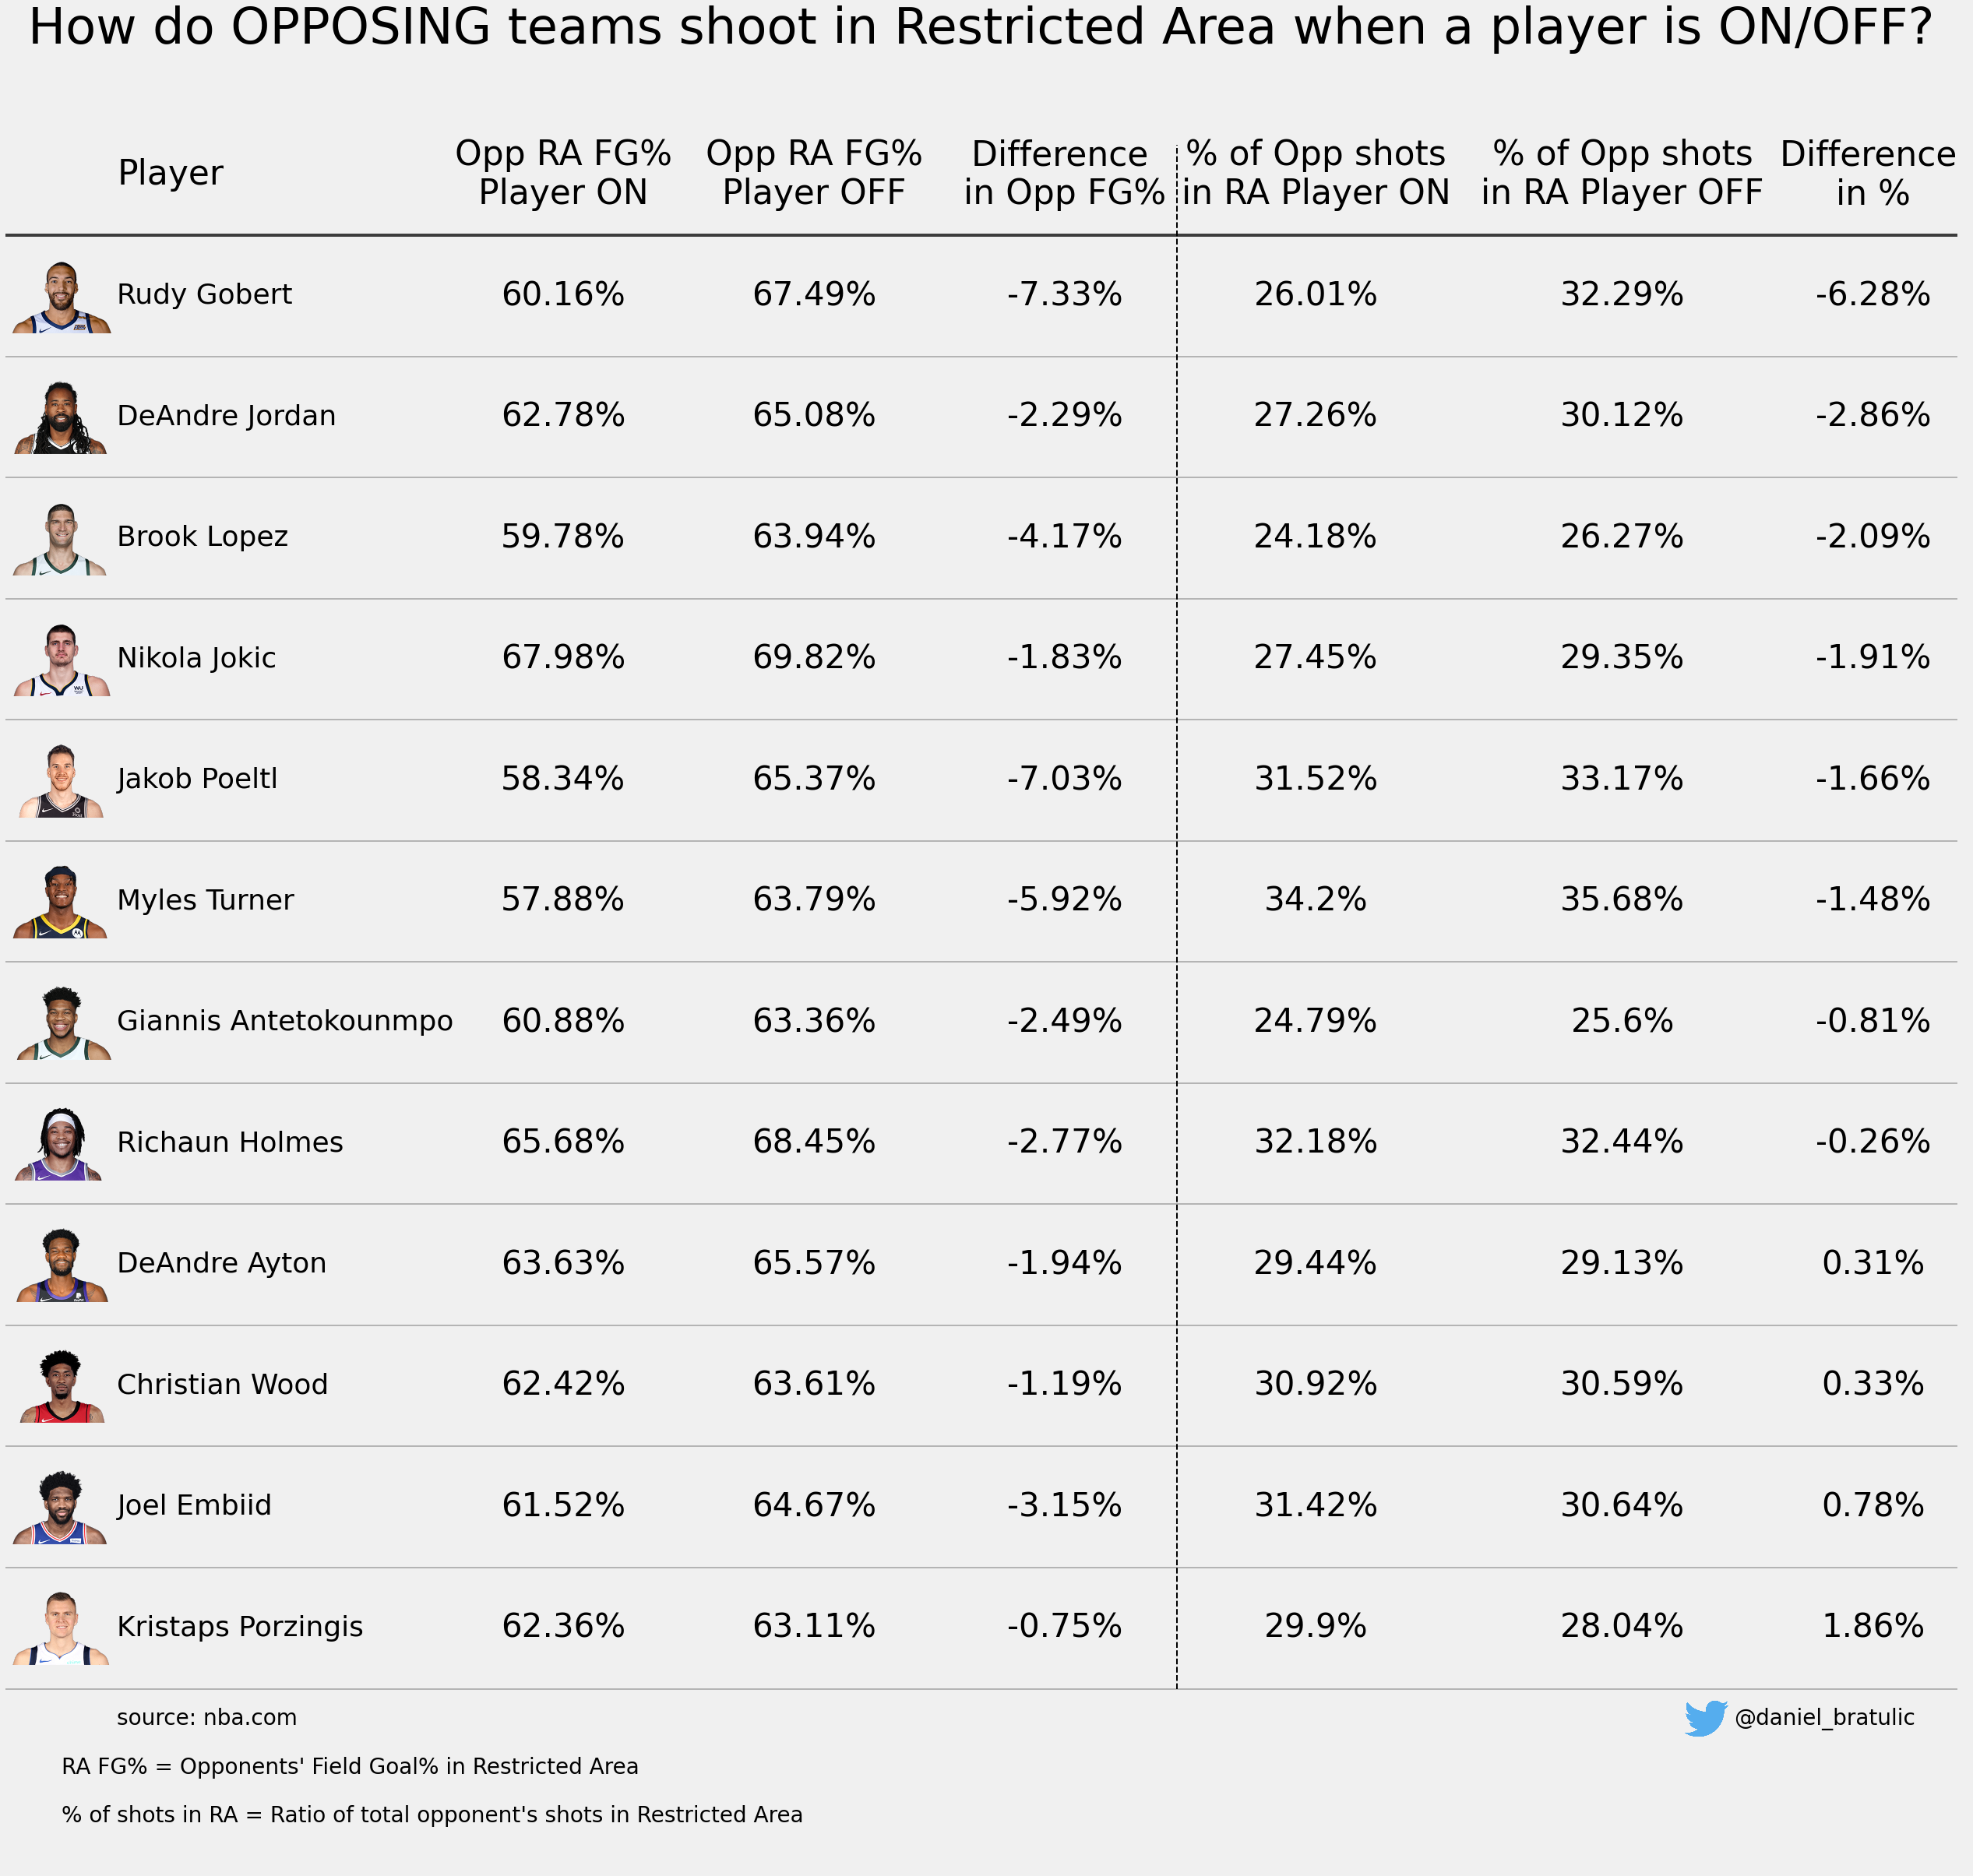

In [252]:
fig, ax = plt.subplots(figsize=(40, 40))
number_size = 42
font_size = 36
font_title = 44
title_size = 64
#top = 10

sorted_open_df = ra_diff_sort
top = len(ra_diff_sort)
for i in range(top):
    item = ra_diff_sort.iloc[i]
    try:
        player_id = find_players_by_full_name(item.PLAYER)[0]['id']
    except Exception:
        continue
    y_coord = top - i - 1
    #if i % 2 == 1:
    #    color = '#EAE8E8'
    #    rect = Rectangle((-4.5, y_coord + 0.5), width=50, height=1, fill=True, color=color)
    #    ax.add_patch(rect)
    
    ab = AnnotationBbox(get_player_img(player_id), (0.2, y_coord), frameon=False)
    ax.add_artist(ab)
    #ax.text(x=0.25, y=y_coord, ha='left', va='center', s=item.SEASON, size=font_size)
    ax.text(x=0.4, y=y_coord, ha='left', va='center', s=item.PLAYER, size=font_size)
    ax.axhline(y=y_coord-0.5, xmin=-0.25, xmax=30, color='#A0A0A0', alpha=0.75, lw=2)

    ax.text(x=2.0, y=y_coord, ha='center', va='center', s=f"{item.RA_FG_PCT_ON}%", size=number_size)
    ax.text(x=2.9, y=y_coord, ha='center', va='center', s=f"{item.RA_FG_PCT_OFF}%", size=number_size)
    ax.text(x=3.8, y=y_coord, ha='center', va='center', s=f"{item.RA_FG_PCT_DIFF:.2f}%", size=number_size)
    ax.text(x=4.7, y=y_coord, ha='center', va='center', s=f"{item.RA_FG_RATE_ON}%", size=number_size)
    ax.text(x=5.8, y=y_coord, ha='center', va='center', s=f"{item.RA_FG_RATE_OFF}%", size=number_size)
    ax.text(x=6.7, y=y_coord, ha='center', va='center', s=f"{item.RA_FG_RATE_DIFF:.2f}%", size=number_size)
    
    #y_img_start = y_coord-0.5 + (1 - 0.730769232) / 2
    #ax.imshow(img, extent=(0, 1.36, y_img_start-0.5, y_img_start + 0.1), aspect='auto')
    #ax.imshow(img, extent=(0, 260, 0, 190), aspect=260/190)
    
#ax.text(x=0.25, y=top, s='Season', ha='left', va='center', size=font_title)

ax.text(x=0.4, y=top, s='Player', ha='left', va='center', size=font_title)
ax.text(x=2.0, y=top, ha='center', va='center', s="Opp RA FG%\nPlayer ON", size=font_title)
ax.text(x=2.9, y=top, ha='center', va='center', s="Opp RA FG%\nPlayer OFF", size=font_title)
ax.text(x=3.8, y=top, ha='center', va='center', s="Difference \nin Opp FG%", size=font_title)
ax.text(x=4.7, y=top, ha='center', va='center', s="% of Opp shots\nin RA Player ON", size=font_title)
ax.text(x=5.8, y=top, ha='center', va='center', s="% of Opp shots\nin RA Player OFF", size=font_title)
ax.text(x=6.7, y=top, ha='center', va='center', s="Difference \nin %", size=font_title)
#ax.text(x=2.7, y=top, ha='center', va='center', s="Recovered%", size=font_title)

#ax.text(x=2.75, y=-0.75, s='twitter: @daniel_bratulic', ha='right', va='center', size=30)
#ax.text(x=0.25, y=-0.75, s='data: nba.com', ha='left', va='center', size=30)
ax.axhline(y=top-0.5, xmin=-0.25, xmax=30, color='black', alpha=0.75, lw=4)
ax.axvline(x=4.2, ymin=0.1, ymax=0.95, lw=2, color='black', ls='--')
ax.set_title("How do OPPOSING teams shoot in Restricted Area when a player is ON/OFF?", size=title_size)
    
ax.set_ylim(bottom=-2, top=top+1)
ax.set_xlim(left=-0, right=7)
ax.grid(False)
ax.set_frame_on(False)
ax.set_yticklabels([])
ax.set_xticklabels([])
ab = AnnotationBbox(OffsetImage(plt.imread(f'../../twitter_logo.png'), zoom=0.05), (6.1, -0.75), frameon=False)
ax.add_artist(ab)
ax.text(x=6.2, y=-0.8, ha='left', s='@daniel_bratulic', size=28)
ax.text(x=0.4, y=-0.8, ha='left', s='source: nba.com', size=28)
ax.text(x=0.2, y=-1.2, s="RA FG% = Opponents' Field Goal% in Restricted Area", size=28)
ax.text(x=0.2, y=-1.6, s="% of shots in RA = Ratio of total opponent's shots in Restricted Area", size=28)
plt.savefig('block_recoveries.png', dpi=120, bbox_inches='tight')

## Detailed look at Rudy

In [21]:
import random
from matplotlib.patches import Circle, Rectangle, Arc

# Amazing function by Bradley Fay for plotting the nba court
# source: https://github.com/bradleyfay/py-Goldsberry/blob/master/docs/Visualizing%20NBA%20Shots%20with%20py-Goldsberry.ipynb
def draw_court(ax=None, color='black', lw=2, background_color="#EBEBE8", outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False, zorder=0)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False, zorder=0)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False, zorder=0)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed', zorder=0)
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color, zorder=0)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 138, linewidth=lw,
                               color=color, zorder=0)
    corner_three_b = Rectangle((220, -47.5), 0, 138, linewidth=lw, color=color, zorder=0)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22.13, theta2=157.87, linewidth=lw,
                    color=color, zorder=0)

    # Center Court
    center_outer_arc = Arc((0, 422), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color, zorder=0)
    center_inner_arc = Arc((0, 422), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color, zorder=0)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]
    
    # Draw the half court line, baseline and side out bound lines
    outer_lines = Rectangle((-249, -48), 498, 470, linewidth=lw,
                            color=color, fill=None)
    court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

In [49]:
from collections import Counter
import operator
def create_bins(data_frame, bin_number_x = 30, bin_number_y=300 / (500.0 / 30.0), league_average = None,
                width = 500, height = 300, norm_x = 250, norm_y = 48):
    """
    Method which creates bins the dataset into squared grid. This is used so that plot looks nicer than the raw
    locations plot. Along with binning the data, the percentages per zones and for each bin are calculated here
    and added to the copy of data_frame object so they can be used for plotting later.

    :return: Returns the copied  data_frame pandas DataFrame object with additional info about the shots.
    """
    # Binned x and y coordinates
    x_bins, y_bins = [], []
    # Copying the dataset to add more data
    copied_df = data_frame.copy()
    # Keys are basically x_bin and y_bin
    keys = []
    # Counter of shots and shots made per locations
    location_counts, location_made = Counter(), Counter()
    # be found

    # Size of elements in bin, they should be the same
    bin_size_x = float(width) / float(bin_number_x)
    bin_size_y = float(height) / float(bin_number_y)
    # List for locations of shots
    locations_annotated = []
    # Counter of shots and shots made per zone
    zones_counts, zones_made = Counter(), Counter()

    # Maximum size of an element in one bin
    max_size = int((int(bin_size_x) - 1) * (int(bin_size_y) - 1))

    # Keys that are in restricted area will be stored here, this will be used for finding maximum number of shots
    restricted_area_keys = []

    # Dictionary which will determine the color of marker in bin
    percentage_color_dict = {}

    for i in range(len(data_frame)):

        # Row from data frame
        row = data_frame.iloc[i]

        x_shot_orig, y_shot_orig = row.LOC_X, row.LOC_Y

        # Normalize
        x_shot = x_shot_orig + norm_x  # to put minimum to zero
        y_shot = y_shot_orig + norm_y  # to put minimum to zero

        # bin_index = (x_shot / w) * bin_size
        curr_x_bin = 0 if x_shot == 0 else int((x_shot / float(width)) * bin_number_x)
        curr_y_bin = 0 if y_shot == 0 else int((y_shot / float(height)) * bin_number_y)

        # Key for dicts
        key = (curr_x_bin, curr_y_bin)

        if row.SHOT_ZONE_BASIC == "Restricted Area":
            restricted_area_keys.append(key)

        # Counting number of shots made and shots shot
        keys.append(key)
        location_counts[key] += 1
        location_made[key] += row.SHOT_MADE_FLAG

        basic_shot_zone, shot_zone_area = row.SHOT_ZONE_BASIC, row.SHOT_ZONE_AREA
        zone_dist = row.SHOT_ZONE_RANGE

        area_code = shot_zone_area.split("(")[1].split(")")[0]
        if "3" in basic_shot_zone:
            locations_annotated.append("3" + area_code)
        elif "Paint" in basic_shot_zone:
            locations_annotated.append("P" + area_code + zone_dist[0])
        elif "Mid" in basic_shot_zone:
            locations_annotated.append("M" + area_code + zone_dist[0])
        else:
            locations_annotated.append("R" + area_code)

        # Creating key for zones
        zone_key = (basic_shot_zone, shot_zone_area, zone_dist)

        # Counting the occurences based on both bin_key and zone_key, because of that we have dict in dict
        if key in percentage_color_dict:
            if zone_key in percentage_color_dict[key]:
                percentage_color_dict[key][zone_key] = percentage_color_dict[key][zone_key] + 1
            else:
                percentage_color_dict[key][zone_key] = 1
        else:
            percentage_color_dict[key] = {}
            percentage_color_dict[key][zone_key] = 1

        zones_counts[zone_key] += 1

        if row.SHOT_MADE_FLAG:
            zones_made[zone_key] += 1

    shot_locations_percentage = []  # percentage in given bin
    shot_locations_counts = []
    raw_counts = []
    # List which contains comparison for each shot with league average in that zone
    shot_comparison = []
    # List which contains comparison of player's shooting in zone vs league average
    per_zone_comparison = []
    per_zone_percentage = []

    # Finding the maximal number of shots from data
    non_ra = []
    for key in location_counts:
        if key not in restricted_area_keys:
            if location_counts[key] not in non_ra:
                non_ra.append(location_counts[key])

    sorted_non_ra = sorted(non_ra)
    max_out_of_restricted = float(sorted_non_ra[-1])

    for j in range(len(data_frame)):
        key = keys[j]
        x_bin, y_bin = key[0], key[1]
        shot_percent = float(location_made[key]) / location_counts[key]
        # shot_percent = np.clip(shot_percent, 0.3, 0.7)
        shot_locations_percentage.append(shot_percent * 100)
        if league_average is not None:
            # Getting info about zone
            # We are getting that info from
            per_zone_counter_from_percentage_color_dict = percentage_color_dict[key]
            zone_key = max(per_zone_counter_from_percentage_color_dict.items(),
                           key=operator.itemgetter(1))[0]

            shot_zone_basic = zone_key[0]
            shot_zone_area = zone_key[1]
            distance = zone_key[2]

            # Calculating the percentage in current zone
            zone_percent = 0.0 if zone_key not in zones_made else float(zones_made[zone_key]) / \
                                                                  float(zones_counts[zone_key])

            # Retrieving league average percentage for current zone
            avg_percentage = league_average.loc[
                (league_average.SHOT_ZONE_BASIC == shot_zone_basic) &
                (league_average.SHOT_ZONE_AREA == shot_zone_area) &
                (league_average.SHOT_ZONE_RANGE == distance)].FG_PCT.iloc[
                0
            ]
            # Comparison of league average and each shot
            shot_comparison.append(np.clip((shot_percent - avg_percentage) * 100, -10, 10))
            # Comparison of zone and league average
            per_zone_comparison.append(np.clip((zone_percent - avg_percentage) * 100, -10, 10))
            # Percentage of shot in current zone, kinda inaccurate info, good for some other type of plot
            per_zone_percentage.append(zone_percent * 100)

        # Calculating value to which the markers will be scaled later on
        # The data in restricted is scaled to maximum out of restricted area, because players usually have a lot
        # more shots in restricted area
        value_to_scale = max_out_of_restricted if location_counts[key] > max_out_of_restricted else \
            location_counts[key]
        # Storing the data into a list
        shot_locations_counts.append((float(value_to_scale) / max_out_of_restricted) * max_size)

        # Count of shots per bin
        raw_counts.append(location_counts[key])

        # Middle of current and next bin is where we will place the marker in real coordinates
        unbinned_x = int(((x_bin * float(width)) / bin_number_x + (
                (x_bin + 1) * float(width)) / bin_number_x) / 2 - norm_x)
        unbinned_y = int(((y_bin * float(height)) / bin_number_y + (
                (y_bin + 1) * float(height)) / bin_number_y) / 2 - norm_y)

        # Adding binned locations
        x_bins.append(unbinned_x)
        y_bins.append(unbinned_y)

    # Binned locations
    copied_df['BIN_LOC_X'] = x_bins
    copied_df['BIN_LOC_Y'] = y_bins
    # Percentage comparison with league averages
    if league_average is not None:
        # Comparison of each shot with league average for that zone
        copied_df['PCT_LEAGUE_AVG_COMPARISON'] = shot_comparison
        # Comparison of each zone with league average for that zone
        copied_df['PCT_LEAGUE_COMPARISON_ZONE'] = per_zone_comparison
        # Percentage of whole zone (not in comparison with league average)
        copied_df['LOC_ZONE_PERCENTAGE'] = per_zone_percentage
    # Percentage of shots for that location
    copied_df['LOC_PERCENTAGE'] = shot_locations_percentage

    # Scaled count of shots and count of shots per bin
    copied_df['LOC_COUNTS'] = shot_locations_counts
    copied_df['LOC_RAW_COUNTS'] = raw_counts

    return copied_df

In [23]:
text_location_mapping = {
    ('Right Corner 3', 'Right Side(R)', '24+ ft.'): (-235, 50),
    ('Left Corner 3', 'Left Side(L)', '24+ ft.'): (235, 50),
    ('Above the Break 3', 'Center(C)', '24+ ft.'): (0, 260),
    ('Above the Break 3', 'Left Side Center(LC)', '24+ ft.'): (155, 230),
    ('Above the Break 3', 'Right Side Center(RC)', '24+ ft.'): (-155, 230),
    ('Restricted Area', 'Center(C)', 'Less Than 8 ft.'): (0, 20),
    ('Mid-Range', 'Center(C)', '16-24 ft.'): (0, 190),
    ('Mid-Range', 'Center(C)', '8-16 ft.') : (0, 150),  # merge prethodni
    ('Mid-Range', 'Left Side Center(LC)', '16-24 ft.'): (110, 180),
    ('Mid-Range', 'Right Side Center(RC)', '16-24 ft.'): (-110, 180),
    ('In The Paint (Non-RA)', 'Center(C)', '8-16 ft.'): (0, 110),
    ('In The Paint (Non-RA)', 'Center(C)', 'Less Than 8 ft.'): (0, 60),
    ('In The Paint (Non-RA)', 'Left Side(L)', '8-16 ft.'): (70, 80),  # merge s ovim dole
    ('Mid-Range', 'Left Side(L)', '8-16 ft.'): (120, 50),
    ('In The Paint (Non-RA)', 'Right Side(R)', '8-16 ft.'): (-70, 80),  # merge s ovim dole
    ('Mid-Range', 'Right Side(R)', '8-16 ft.'): (-120, 50),
    ('Mid-Range', 'Left Side(L)', '16-24 ft.'): (190, 50),
    ('Mid-Range', 'Right Side(R)', '16-24 ft.'): (-190, 50),
}

In [24]:
pl_id = find_players_by_full_name("Rudy Gobert")[0]['id']

player_on_floor = get_on_floor(pl_id, full_df)
player_off_floor = get_off_floor(pl_id, full_df)
player_off_floor = player_off_floor.loc[player_off_floor.GAME_ID.isin(player_on_floor.GAME_ID.unique())]

In [25]:
team_id = find_teams_by_full_name("Utah Jazz")[0]['id']

In [26]:
opposing_shots_on = player_on_floor.loc[((player_on_floor.EVENTMSGTYPE == 1) | (player_on_floor.EVENTMSGTYPE == 2)) & (player_on_floor.PLAYER1_TEAM_ID != team_id)]

In [27]:
shot_on_court = pd.merge(left=shotchart_all, right=opposing_shots_on, left_on=('GAME_ID', 'GAME_EVENT_ID'), right_on=('GAME_ID', 'EVENTNUM'))

In [28]:
x_on = shot_on_court.LOC_X.to_numpy()

In [29]:
y_on = shot_on_court.LOC_Y.to_numpy()

In [181]:
bin_number_x = 50
bin_number_y = 300 / (500.0 / bin_number_x)

In [183]:
binned_df = create_bins(data_frame=shot_on_court, bin_number_x=bin_number_x, bin_number_y=bin_number_y)

grouped_bins = binned_df.groupby(('BIN_LOC_X', 'BIN_LOC_Y')).SHOT_ATTEMPTED_FLAG.count().reset_index()

grouped_bins.SHOT_ATTEMPTED_FLAG = grouped_bins.SHOT_ATTEMPTED_FLAG / len(binned_df) * 100

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  """Entry point for launching an IPython kernel.


In [185]:
binned_df = create_bins(data_frame=shot_off_court, bin_number_x=bin_number_x, bin_number_y=bin_number_y)

grouped_off_bins = binned_df.groupby(('BIN_LOC_X', 'BIN_LOC_Y')).SHOT_ATTEMPTED_FLAG.count().reset_index()

grouped_off_bins.SHOT_ATTEMPTED_FLAG = grouped_off_bins.SHOT_ATTEMPTED_FLAG / len(binned_df) * 100

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  This is separate from the ipykernel package so we can avoid doing imports until


In [186]:
merged_binned = pd.merge(left=grouped_bins, right=grouped_off_bins, on=('BIN_LOC_X', 'BIN_LOC_Y'), suffixes=('_ON', '_OFF'))

In [187]:
merged_binned.loc[:, 'DIFF'] = merged_binned.SHOT_ATTEMPTED_FLAG_ON - merged_binned.SHOT_ATTEMPTED_FLAG_OFF

In [188]:
merged_binned.sort_values(by='DIFF', ascending=False).head()

BIN_LOC_X  BIN_LOC_Y  SHOT_ATTEMPTED_FLAG_ON  SHOT_ATTEMPTED_FLAG_OFF  \
582        225          7                0.620018                 0.268017   
231        -25         17                1.062888                 0.714711   
505        115        237                0.383820                 0.089339   
142        -85        237                0.442870                 0.178678   
220        -35         97                0.265722                 0.029780   

         DIFF  
582  0.352001  
231  0.348176  
505  0.294482  
142  0.264192  
220  0.235942

In [197]:
cmap = sns.color_palette("coolwarm", n_colors=6, desat=1)


In [203]:
cmap

[array([0.88339877, 0.63774563, 0.93301505, 1.        ]),
 array([0.92092707, 0.75433781, 0.95457427, 1.        ]),
 array([0.95845538, 0.87092999, 0.97613349, 1.        ]),
 array([0.98027788, 0.87883069, 0.86352671, 1.        ]),
 array([0.96176023, 0.76506138, 0.73538806, 1.        ]),
 array([0.94324258, 0.65129207, 0.60724941, 1.        ])]

In [217]:
cmap = sns.diverging_palette(240, 10, n=6, as_cmap=False, l=50, s=80)

In [218]:
colors = []
for diff in merged_binned.DIFF:
    if diff < -1.5:
        colors.append(cmap[0])
    if diff > -1.5 and diff <= -0.5:
        colors.append(cmap[1])
    if diff > -0.5 and diff <= 0:
        colors.append(cmap[2])
    if diff > 0 and diff <= 0.5:
        colors.append(cmap[3])
    if diff > 0.5 and diff <= 1.5:
        colors.append(cmap[4])
    if diff > 1.5:
        colors.append(cmap[5])

<AxesSubplot:title={'center':'Difference in shot frequency when Rudy Gobert is ON/OFF'}>

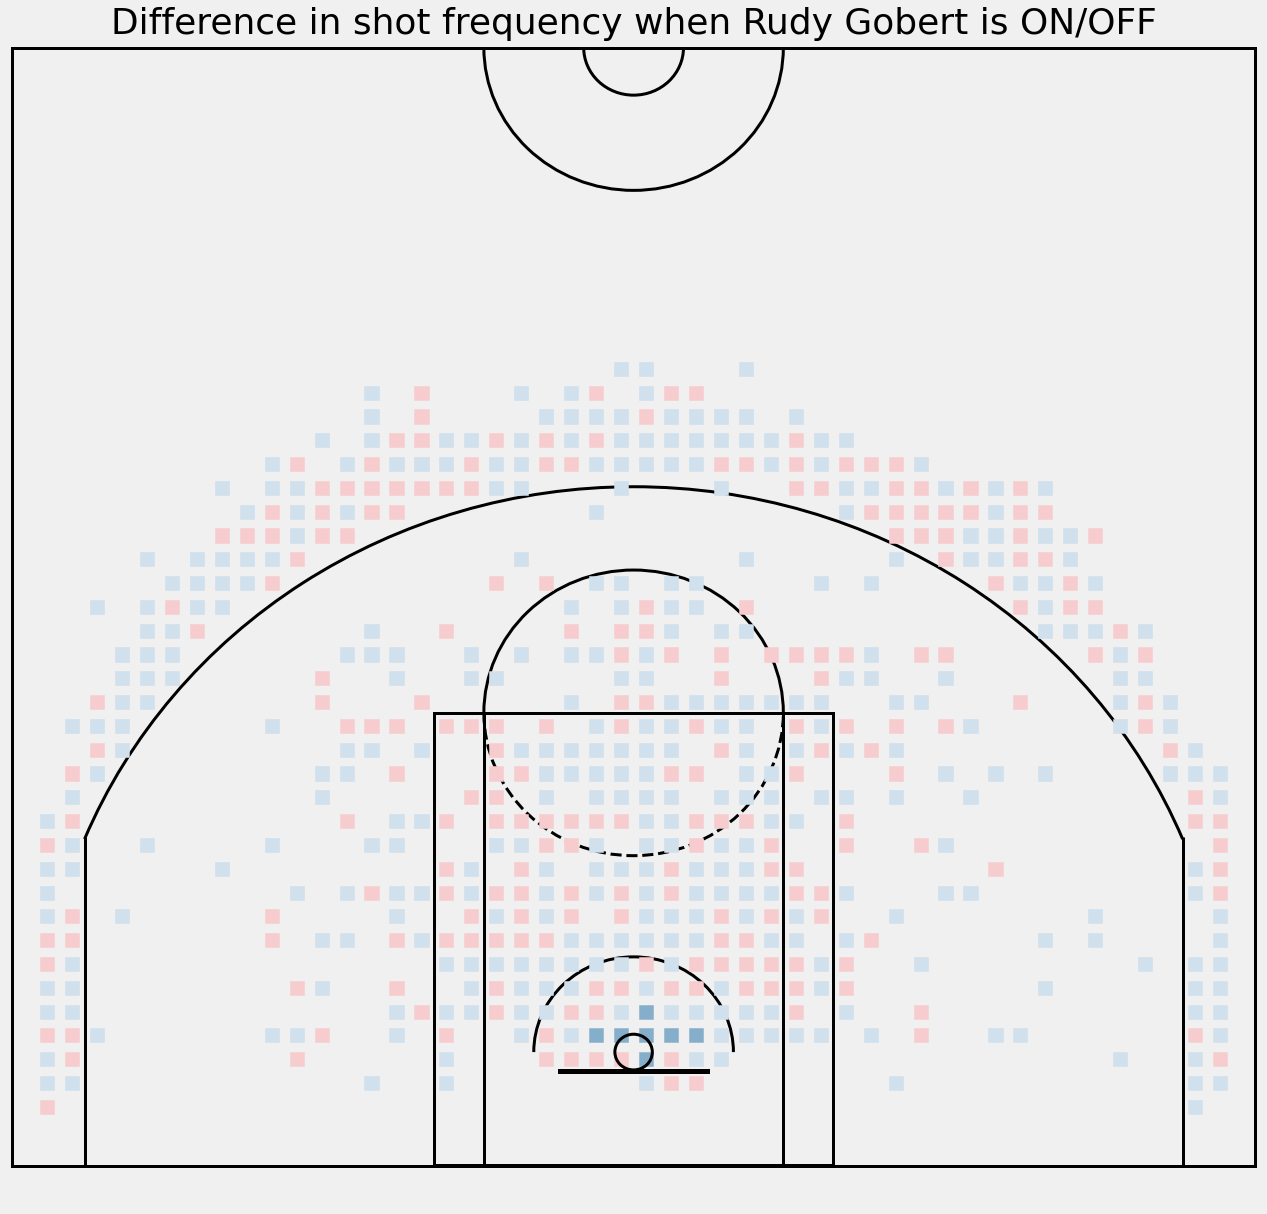

In [219]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
ax.grid(False)
ax.set_xlim(-251,251)
ax.set_ylim(-65,425)

#cmap_list = sns.blend_palette(colors=["#4159E1", "#B0E0E6", "#FFFF99","#EF3330", "#AB2020"],n_colors=20, as_cmap=False)
cmap = sns.diverging_palette(240, 10, n=9, sep=10, as_cmap=True)
ax.set_title("Difference in shot frequency when Rudy Gobert is ON/OFF", size=36)
#sns.kdeplot(data=merged_binned.BIN_LOC_X, data2=merged_binned.BIN_LOC_Y, hue=merged_binned.DIFF, ax=ax, fill=True,shade=True, shade_lowest=False, alpha=0.75, cmap='hot')
ax.scatter(x=merged_binned.BIN_LOC_X, y=merged_binned.BIN_LOC_Y, c=colors, alpha=1.0, s=200, marker='s')
draw_court(ax=ax,outer_lines=True, lw=3, color='black')

In [224]:
from scipy.stats import kde


## Raw

In [164]:
grouped_on_raw = shot_on_court.groupby(('LOC_X', 'LOC_Y')).SHOT_ATTEMPTED_FLAG.count().reset_index()

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  """Entry point for launching an IPython kernel.


### Other tests

<AxesSubplot:title={'center':"Opponent's heat map when Rudy Gobert is ON the court"}>

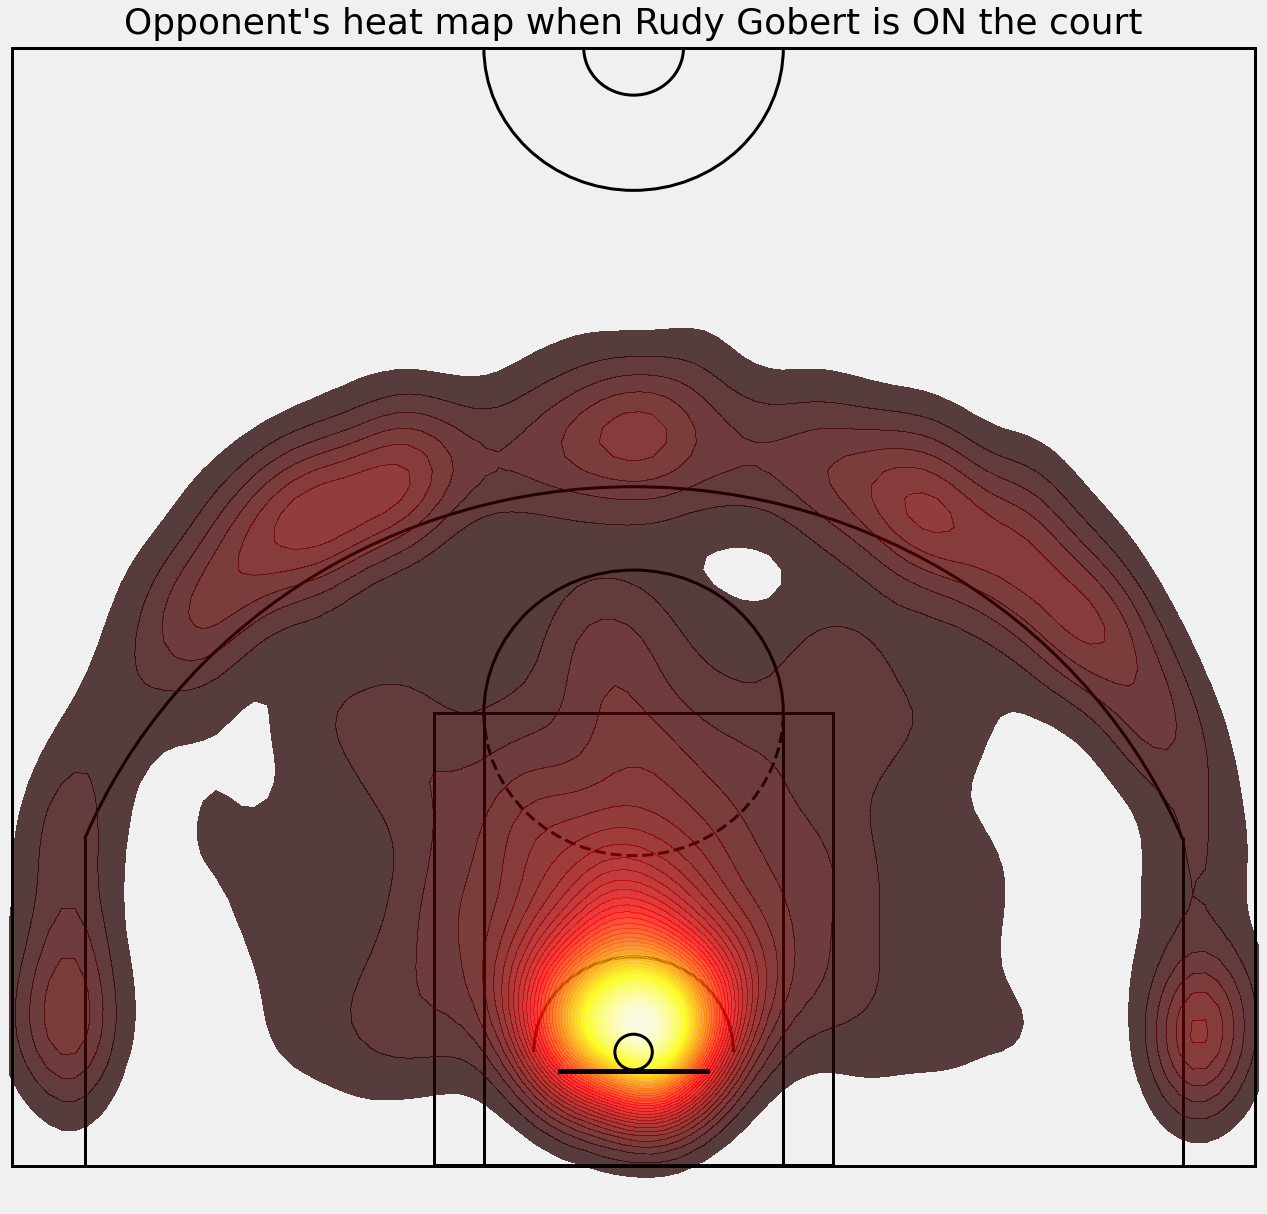

In [131]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
ax.grid(False)
ax.set_xlim(-251,251)
ax.set_ylim(-65,425)

ax.set_title("Opponent's heat map when Rudy Gobert is ON the court", size=36)
sns.kdeplot(data=x_bin_on, data2=y_bin_on, ax=ax, gridsize=100, cut=1, fill=True, levels=50, shade=True, shade_lowest=False, alpha=0.75, cmap='hot')
draw_court(ax=ax,outer_lines=True, lw=3, color='black')

In [31]:
opposing_shots_off = player_off_floor.loc[((player_off_floor.EVENTMSGTYPE == 1) | (player_off_floor.EVENTMSGTYPE == 2)) & (player_off_floor.PLAYER1_TEAM_ID != team_id)]

In [87]:
shot_off_court = pd.merge(left=shotchart_all, right=opposing_shots_off, left_on=('GAME_ID', 'GAME_EVENT_ID'), right_on=('GAME_ID', 'EVENTNUM'))

x_off = shot_off_court.LOC_X.to_numpy()

y_off = shot_off_court.LOC_Y.to_numpy()

<AxesSubplot:title={'center':"Opponent's heat map when Rudy Gobert is OFF the court"}>

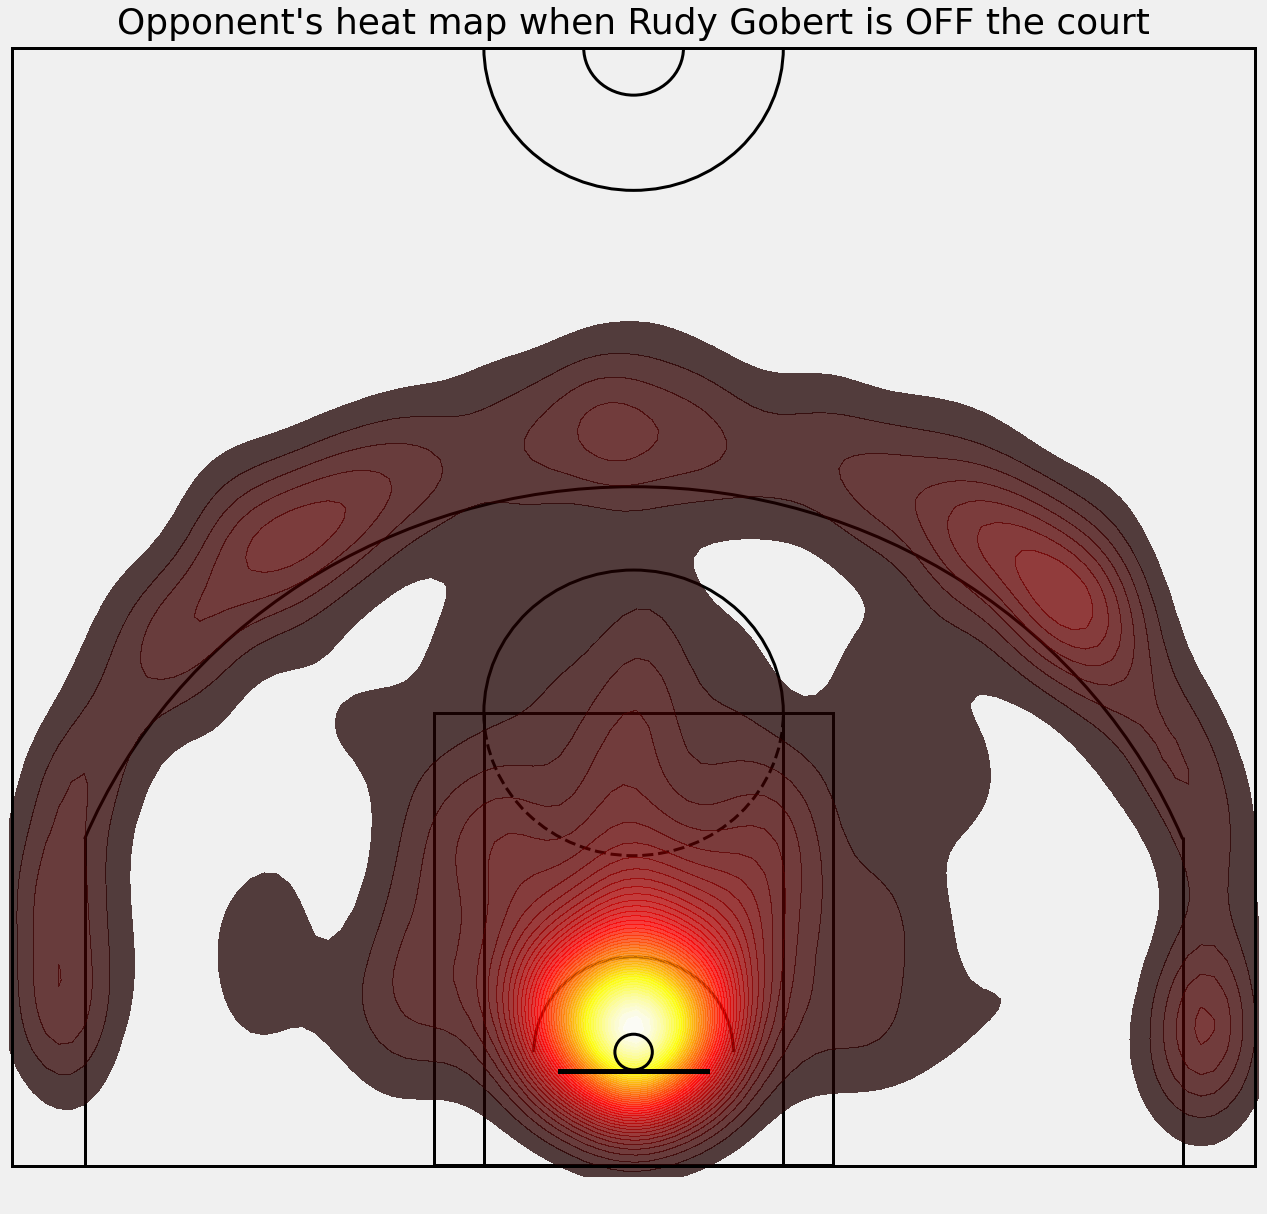

In [108]:
fig, ax = plt.subplots(figsize=(20, 20))
draw_court(ax=ax,outer_lines=True, lw=3, color='black')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
ax.grid(False)
ax.set_xlim(-251,251)
ax.set_ylim(-65,425)

ax.set_title("Opponent's heat map when Rudy Gobert is OFF the court", size=36)
#sns.kdeplot(data=x_on, data2=y_on, ax=ax, cut=1, fill=True, levels=25, shade=True, shade_lowest=False, alpha=0.75)
sns.kdeplot(data=x_off, data2=y_off, ax=ax, cut=1, fill=True, levels=50, shade=True, shade_lowest=False, alpha=0.75, cmap='hot')

<AxesSubplot:title={'center':"Opponent's heat map when Rudy Gobert is OFF the court"}>

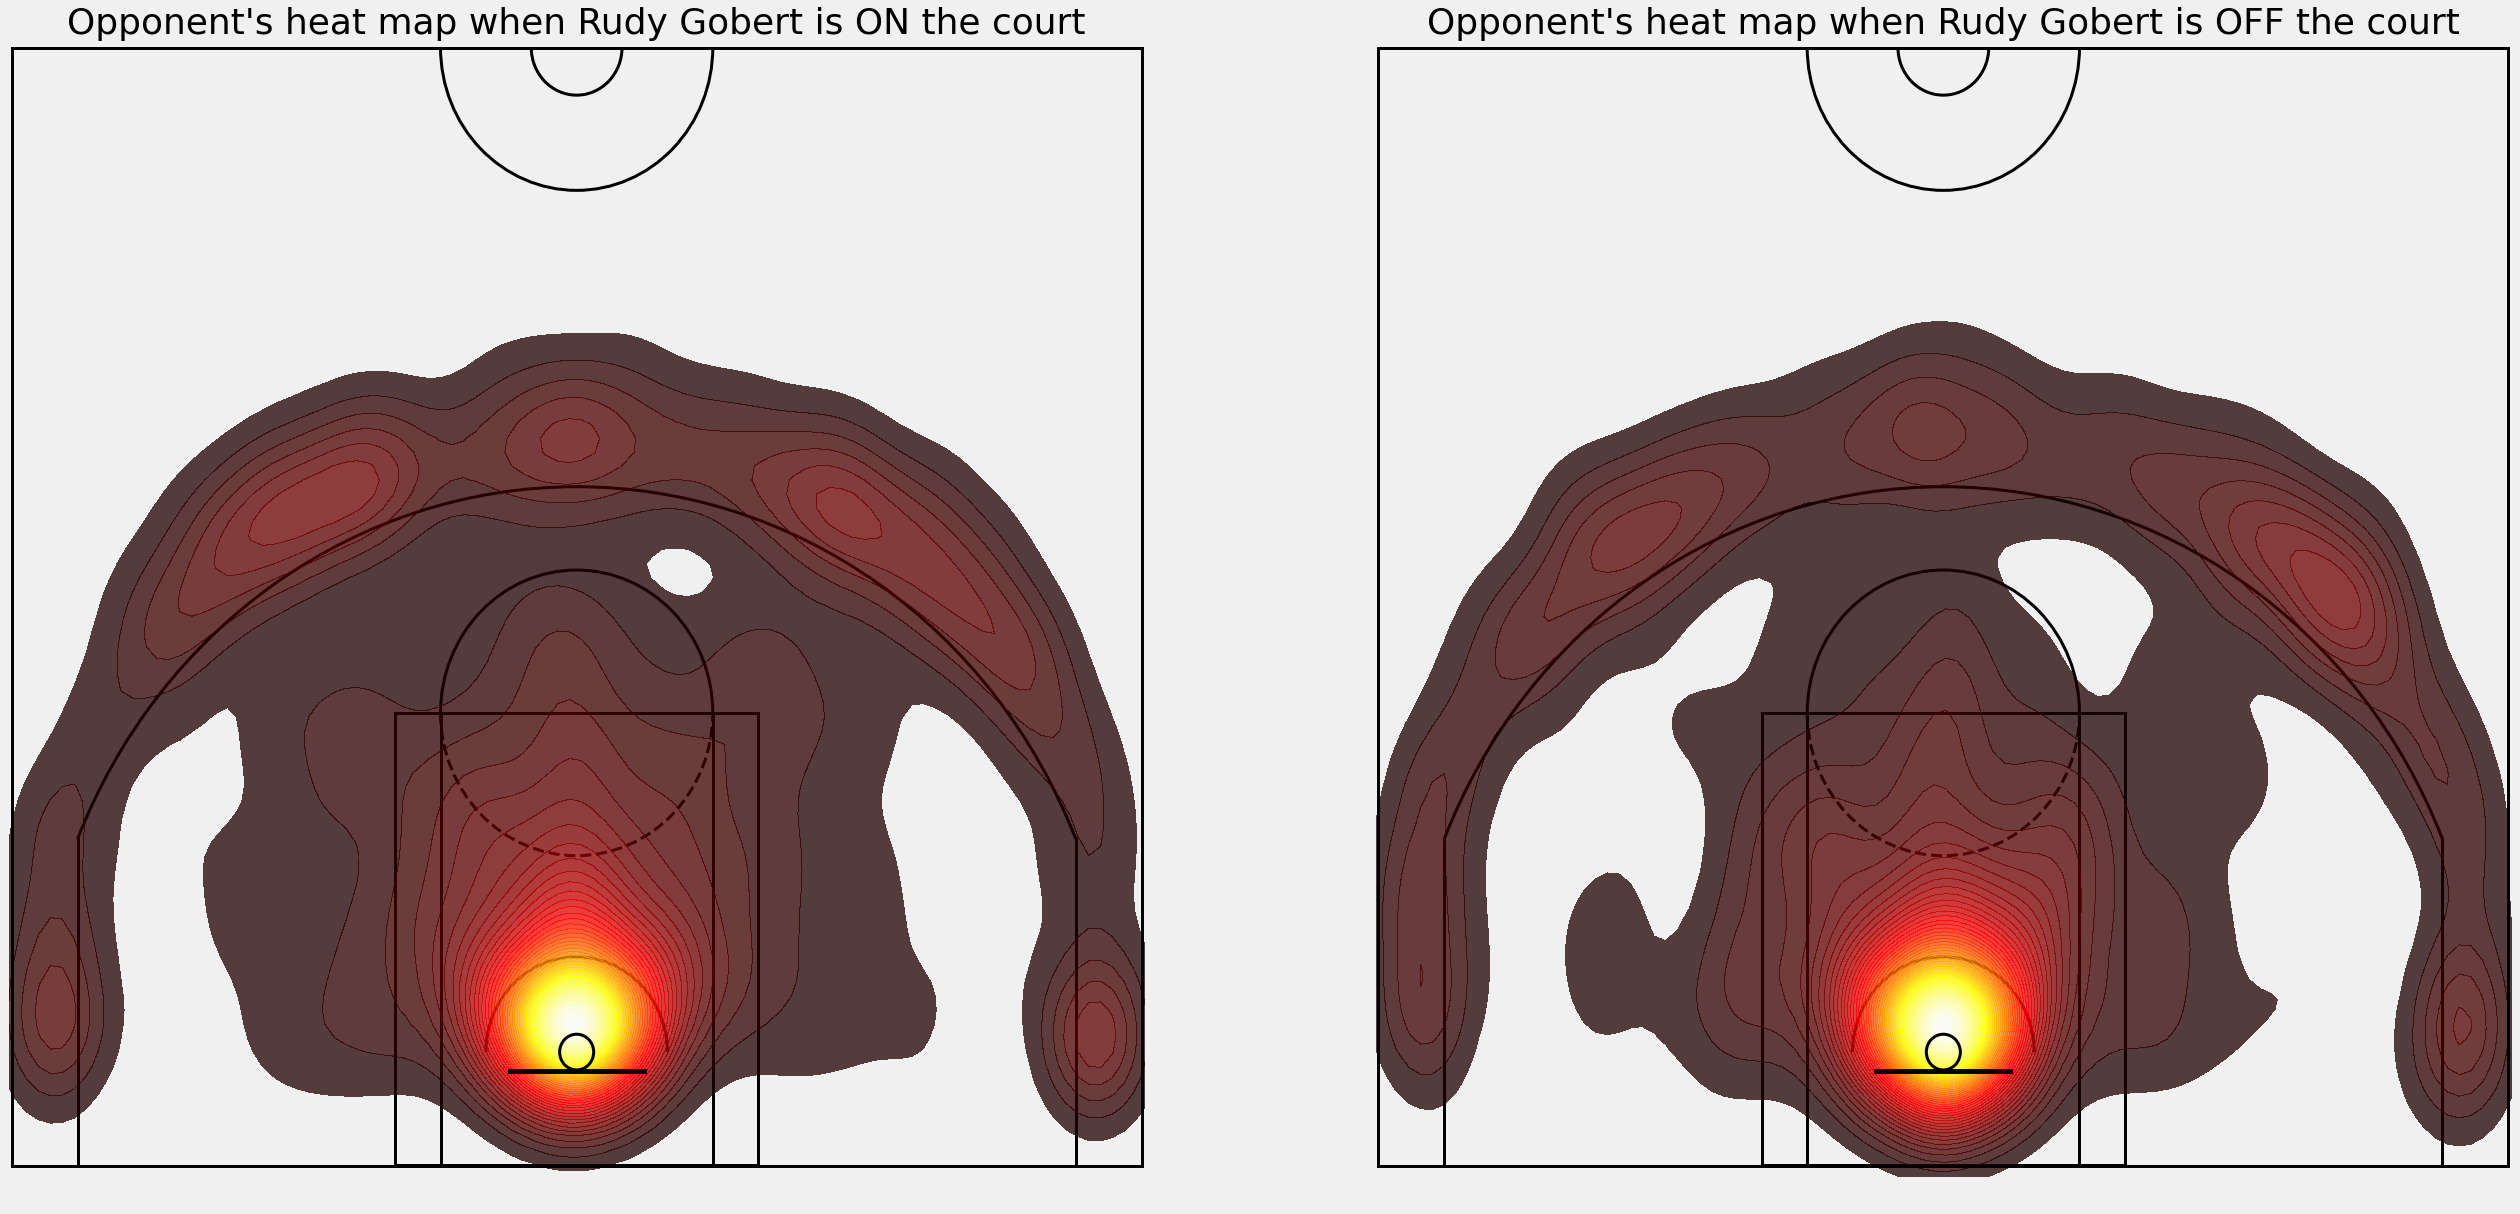

In [125]:
fig, axes = plt.subplots(1, 2, figsize=(40, 20))
ax_1, ax_2 = axes

ax_1.xaxis.set_ticks([])
ax_1.yaxis.set_ticks([])
ax_1.grid(False)
ax_1.set_xlim(-251,251)
ax_1.set_ylim(-65,425)

ax_1.set_title("Opponent's heat map when Rudy Gobert is ON the court", size=36)
sns.kdeplot(data=x_on, data2=y_on, gridsize=100, ax=ax_1, cut=1, fill=True, levels=50, shade=True, shade_lowest=False, alpha=0.75, cmap='hot')
draw_court(ax=ax_1,outer_lines=True, lw=3, color='black')


draw_court(ax=ax_2,outer_lines=True, lw=3, color='black')
ax_2.xaxis.set_ticks([])
ax_2.yaxis.set_ticks([])
ax_2.grid(False)
ax_2.set_xlim(-251,251)
ax_2.set_ylim(-65,425)

ax_2.set_title("Opponent's heat map when Rudy Gobert is OFF the court", size=36)
#sns.kdeplot(data=x_on, data2=y_on, ax=ax, cut=1, fill=True, levels=25, shade=True, shade_lowest=False, alpha=0.75)
sns.kdeplot(data=x_off, data2=y_off, ax=ax_2, gridsize=100, cut=1, fill=True, levels=50, shade=True, shade_lowest=False, alpha=0.75, cmap='hot')

In [150]:
binned_df.loc[:, ['BIN_LOC_X', 'BIN_LOC_Y']]

BIN_LOC_X   BIN_LOC_Y
0     -41.666667   27.000000
1      -8.333333   10.333333
2     125.000000   10.333333
3     -91.666667  243.666667
4     191.666667  143.666667
...          ...         ...
2981    8.333333   43.666667
2982 -141.666667  227.000000
2983 -141.666667  243.666667
2984   25.000000   43.666667
2985   25.000000  277.000000

[2986 rows x 2 columns]